<a href="https://colab.research.google.com/github/vinay10949/AnalyticsAndML/blob/master/Kagg%3Be/Prudential%20Life%20Insurance%20Assessment/Prudential_Kaggle_0_5Kappa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Downloading Data from Kaggle**

In [0]:
!pip install kaggle==1.5.6
!mkdir .kaggle
import json
token = {"username":"vinay10949","key":"59c4901452f76ce62979e5b0997e240b"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)


In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c prudential-life-insurance-assessment
!unzip train.csv.zip
!unzip test.csv.zip

In [0]:
!pip install catboost
!pip install feature_engine

## **Importing Libraries**

In [0]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

import catboost as ct
from sklearn.preprocessing import FunctionTransformer, PowerTransformer

from sklearn.model_selection import train_test_split

from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.metrics import cohen_kappa_score
from feature_engine.outlier_removers import Winsorizer

from sklearn.preprocessing import PolynomialFeatures


In [9]:
!pip install catboost

     |████████████████████████████████| 64.4MB 45kB/s 


**<h2>VARIABLE TYPES</h2>**
 The following variables are all categorical (nominal):

Product_Info_1, Product_Info_2, Product_Info_3, Product_Info_5, Product_Info_6, Product_Info_7, Employment_Info_2, Employment_Info_3, Employment_Info_5, InsuredInfo_1, InsuredInfo_2, InsuredInfo_3, InsuredInfo_4, InsuredInfo_5, InsuredInfo_6, InsuredInfo_7, Insurance_History_1, Insurance_History_2, Insurance_History_3, Insurance_History_4, Insurance_History_7, Insurance_History_8, Insurance_History_9, Family_Hist_1, Medical_History_2, Medical_History_3, Medical_History_4, Medical_History_5, Medical_History_6, Medical_History_7, Medical_History_8, Medical_History_9, Medical_History_11, Medical_History_12, Medical_History_13, Medical_History_14, Medical_History_16, Medical_History_17, Medical_History_18, Medical_History_19, Medical_History_20, Medical_History_21, Medical_History_22, Medical_History_23, Medical_History_25, Medical_History_26, Medical_History_27, Medical_History_28, Medical_History_29, Medical_History_30, Medical_History_31, Medical_History_33, Medical_History_34, Medical_History_35, Medical_History_36, Medical_History_37, Medical_History_38, Medical_History_39, Medical_History_40, Medical_History_41

The following variables are continuous:

Product_Info_4, Ins_Age, Ht, Wt, BMI, Employment_Info_1, Employment_Info_4, Employment_Info_6, Insurance_History_5, Family_Hist_2, Family_Hist_3, Family_Hist_4, Family_Hist_5

The following variables are discrete:

Medical_History_1, Medical_History_10, Medical_History_15, Medical_History_24, Medical_History_32

Medical_Keyword_1-48 are dummy variables.

In [0]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

In [7]:
train['Response'].value_counts()

8    19489
6    11233
7     8027
2     6552
1     6207
5     5432
4     1428
3     1013
Name: Response, dtype: int64

# **Converting Nominal Variables to category,discrete to int64 and continous to float64** ##

## **Helper Functions**##

In [0]:
lstCategorical=['Product_Info_1','Product_Info_2','Product_Info_3','Product_Info_5','Product_Info_6','Product_Info_7','Employment_Info_2','Employment_Info_3','Employment_Info_5','InsuredInfo_1','InsuredInfo_2','InsuredInfo_3','InsuredInfo_4','InsuredInfo_5','InsuredInfo_6','InsuredInfo_7','Insurance_History_1','Insurance_History_2','Insurance_History_3','Insurance_History_4','Insurance_History_7','Insurance_History_8','Insurance_History_9','Family_Hist_1','Medical_History_2','Medical_History_3','Medical_History_4','Medical_History_5','Medical_History_6','Medical_History_7','Medical_History_8','Medical_History_9','Medical_History_11','Medical_History_12','Medical_History_13','Medical_History_14','Medical_History_16','Medical_History_17','Medical_History_18','Medical_History_19','Medical_History_20','Medical_History_21','Medical_History_22','Medical_History_23','Medical_History_25','Medical_History_26','Medical_History_27','Medical_History_28','Medical_History_29','Medical_History_30','Medical_History_31','Medical_History_33','Medical_History_34','Medical_History_35','Medical_History_36','Medical_History_37','Medical_History_38','Medical_History_39','Medical_History_40','Medical_History_41']
lstContinuous=['Product_Info_4', 'Ins_Age', 'Ht', 'Wt', 'BMI', 'Employment_Info_1', 'Employment_Info_4', 'Employment_Info_6', 'Insurance_History_5', 'Family_Hist_2', 'Family_Hist_3', 'Family_Hist_4', 'Family_Hist_5']
lstDiscrete=['Medical_History_1', 'Medical_History_10', 'Medical_History_15', 'Medical_History_24', 'Medical_History_32','Medical_Keyword_1']

def typeOfKey(k):
  if k in lstCategorical:
    return 'category'
  elif k in lstContinuous:
    return 'continous'
  if k in lstDiscrete:
    return 'discrete'  

def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        listColumns=list(mis_val.reset_index()['index'])
        listColumns.remove('Id')
        listColumns.remove('Response')
        d = {k:typeOfKey(k) for k in listColumns}
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1) 
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        mis_val_table_ren_columns.reset_index(inplace=True)
        #mis_val_table_ren_columns['type'] = mis_val_table_ren_columns.apply(lambda row: d[row['index']], axis = 1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns




def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments
    # define figure size
    plt.figure(figsize=(16, 4))
    # histogram
    plt.subplot(1, 4, 1)
    sns.distplot(df[variable], bins=30)
    plt.title('Histogram')
    # Q-Q plot
    plt.subplot(1, 4, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('RM quantiles')
    # boxplot
    plt.subplot(1, 4, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')
    plt.show()

def rare_encoding(X_train, X_test, variable, tolerance):
    X_train = X_train.copy()
    X_test = X_test.copy()
    # find the most frequent category
    frequent_cat = find_non_rare_labels(X_train, variable, tolerance)
    # re-group rare labels
    X_train[variable] = np.where(X_train[variable].isin(
        frequent_cat), X_train[variable], 'Rare')
    
    X_test[variable] = np.where(X_test[variable].isin(
        frequent_cat), X_test[variable], 'Rare')
    return X_train, X_test


def find_non_rare_labels(df, variable, tolerance):
    
    temp = df.groupby([variable])[variable].count() / len(df)
    
    non_rare = [x for x in temp.loc[temp>tolerance].index.values]
    
    return non_rare

## **Preprocessing Step 1 Imputing missing values** 

In [410]:
missing_report=missing_values_table(train).reset_index()
print("After Dropping columns ",missing_report)
columnsToBeDropped=missing_report[missing_report['% of Total Values']>15]['index'].to_list()


Your selected dataframe has 128 columns.
There are 13 columns that have missing values.
After Dropping columns      level_0                index  Missing Values  % of Total Values
0         0   Medical_History_10           58824               99.1
1         1   Medical_History_32           58274               98.1
2         2   Medical_History_24           55580               93.6
3         3   Medical_History_15           44596               75.1
4         4        Family_Hist_5           41811               70.4
5         5        Family_Hist_3           34241               57.7
6         6        Family_Hist_2           28656               48.3
7         7  Insurance_History_5           25396               42.8
8         8        Family_Hist_4           19184               32.3
9         9    Employment_Info_6           10854               18.3
10       10    Medical_History_1            8889               15.0
11       11    Employment_Info_4            6779               11.4
12  

In [0]:

#Drop Employment_Info_4 since low variance
train.drop('Employment_Info_4',axis=1,inplace=True)
test.drop('Employment_Info_4',axis=1,inplace=True)

In [0]:
train=train.drop(columnsToBeDropped,axis=1)
test=test.drop(columnsToBeDropped,axis=1)

In [413]:
missing_values_table(train).reset_index()['index']

medicalHistoryMedian=np.nanmedian(train['Medical_History_1'])
employment_Info_1Median=np.nanmedian(train['Employment_Info_1'])

train['Employment_Info_1']=train['Employment_Info_1'].fillna(employment_Info_1Median)
train['Medical_History_1']=train['Medical_History_1'].fillna(medicalHistoryMedian)
test['Employment_Info_1']=test['Employment_Info_1'].fillna(employment_Info_1Median)
test['Medical_History_1']=test['Medical_History_1'].fillna(medicalHistoryMedian)



Your selected dataframe has 117 columns.
There are 2 columns that have missing values.


## **Preprocessing Step 2 Transforming Datatypes** 

In [0]:
lstCategorical=['Product_Info_1','Product_Info_2','Product_Info_3','Product_Info_5','Product_Info_6','Product_Info_7','Employment_Info_2','Employment_Info_3','Employment_Info_5','InsuredInfo_1','InsuredInfo_2','InsuredInfo_3','InsuredInfo_4','InsuredInfo_5','InsuredInfo_6','InsuredInfo_7','Insurance_History_1','Insurance_History_2','Insurance_History_3','Insurance_History_4','Insurance_History_7','Insurance_History_8','Insurance_History_9','Family_Hist_1','Medical_History_2','Medical_History_3','Medical_History_4','Medical_History_5','Medical_History_6','Medical_History_7','Medical_History_8','Medical_History_9','Medical_History_11','Medical_History_12','Medical_History_13','Medical_History_14','Medical_History_16','Medical_History_17','Medical_History_18','Medical_History_19','Medical_History_20','Medical_History_21','Medical_History_22','Medical_History_23','Medical_History_25','Medical_History_26','Medical_History_27','Medical_History_28','Medical_History_29','Medical_History_30','Medical_History_31','Medical_History_33','Medical_History_34','Medical_History_35','Medical_History_36','Medical_History_37','Medical_History_38','Medical_History_39','Medical_History_40','Medical_History_41']
lstContinuous=['Product_Info_4', 'Ins_Age', 'Ht', 'Wt', 'BMI', 'Employment_Info_1', 'Employment_Info_4', 'Employment_Info_6', 'Insurance_History_5', 'Family_Hist_2', 'Family_Hist_3', 'Family_Hist_4', 'Family_Hist_5']
lstDiscrete=['Medical_History_1', 'Medical_History_10', 'Medical_History_15', 'Medical_History_24', 'Medical_History_32','Medical_Keyword_1']

lstCategorical=[x for x in train.columns if x in lstCategorical]

lstContinuous=[x for x in train.columns if x in lstContinuous]

lstDiscrete=[x for x in train.columns if x in lstDiscrete]

train[lstCategorical]=train[lstCategorical].apply(lambda x: x.astype('category'))
test[lstCategorical]=test[lstCategorical].apply(lambda x: x.astype('category'))

train[lstContinuous]=train[lstContinuous].apply(lambda x: x.astype('float64'))
test[lstContinuous]=test[lstContinuous].apply(lambda x: x.astype('float64'))

train[lstDiscrete]=train[lstDiscrete].apply(lambda x: x.astype('int64'))
test[lstDiscrete]=test[lstDiscrete].apply(lambda x: x.astype('int64'),)

## **Finding Rare Categories and Grouping it into rare** 

**Rare categories grouped into rare value**

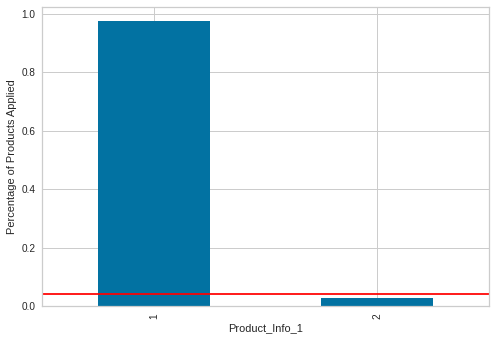

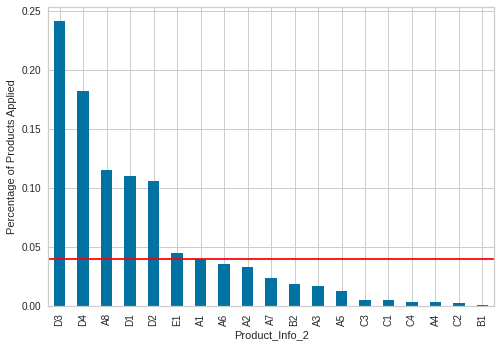

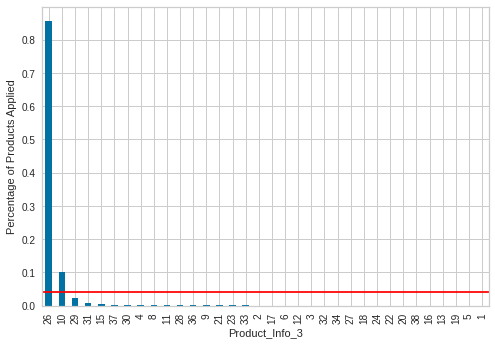

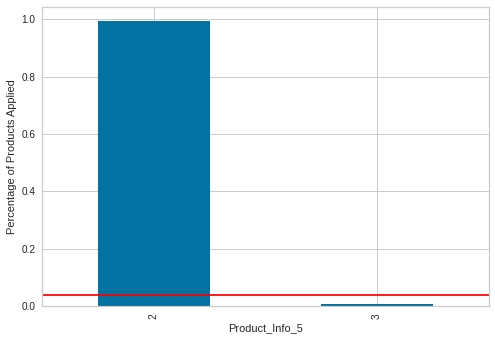

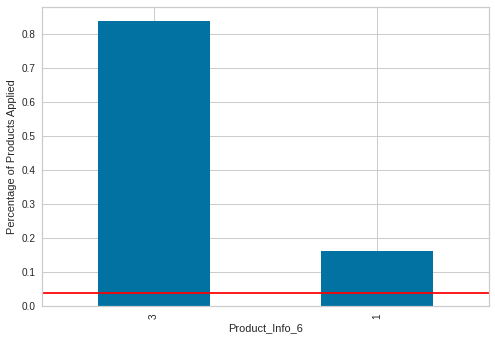

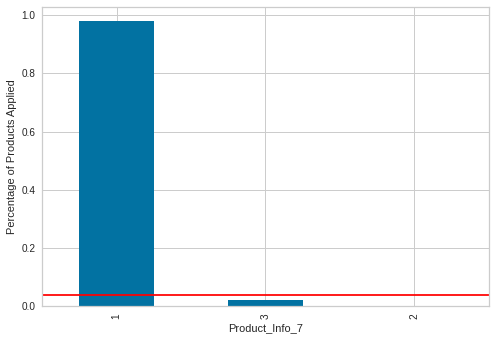

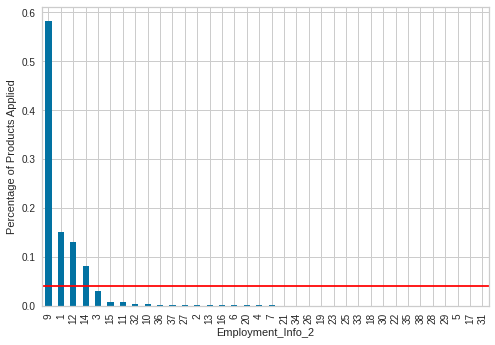

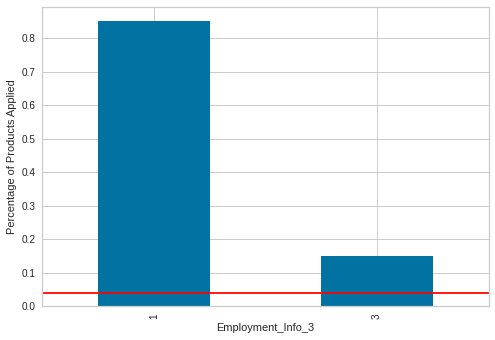

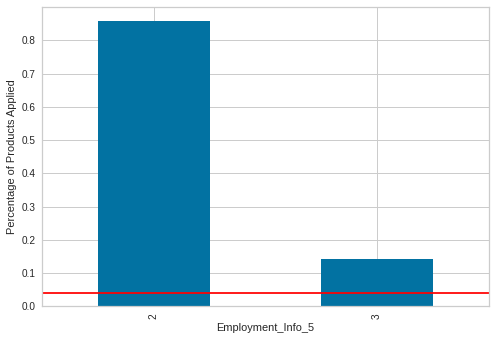

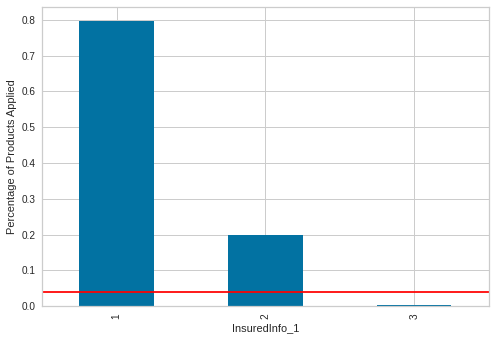

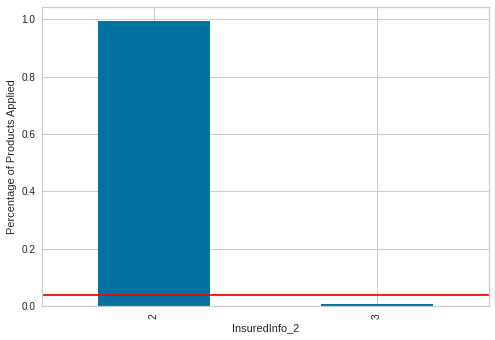

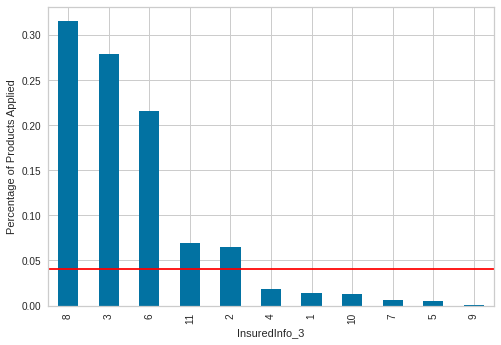

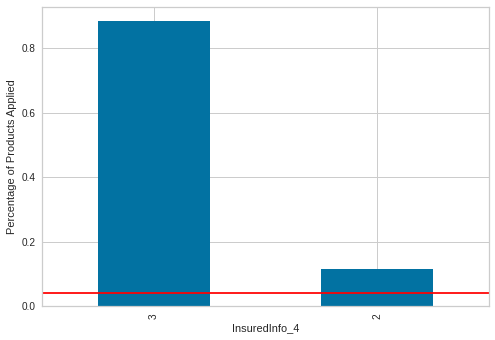

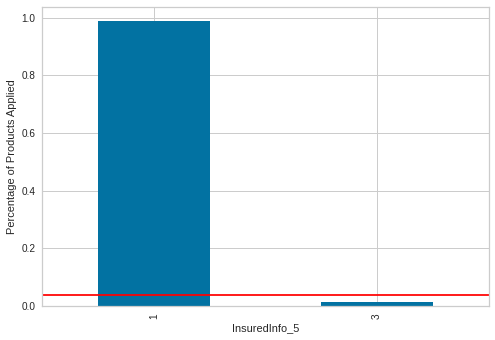

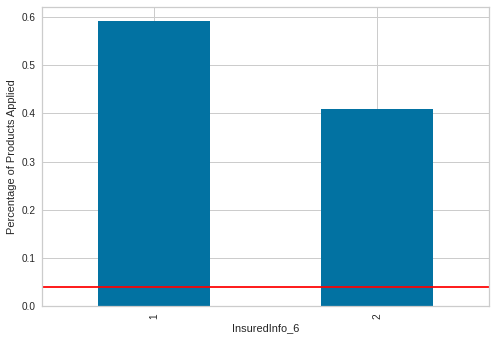

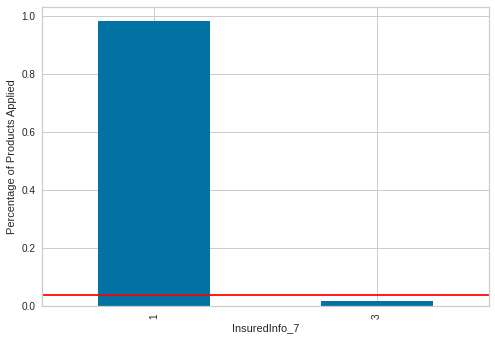

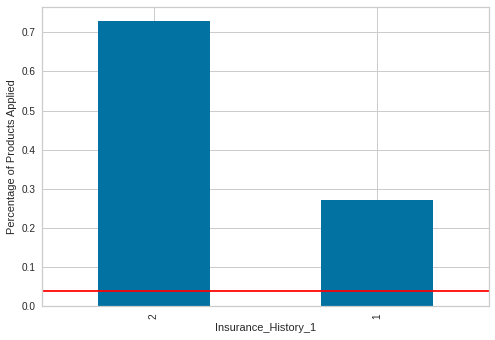

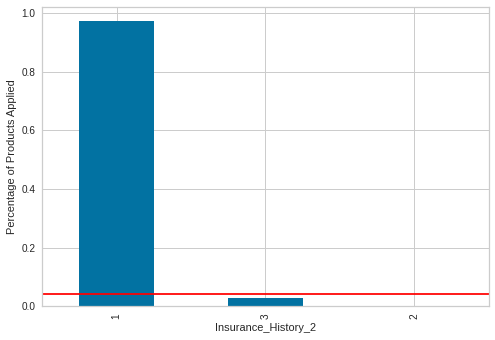

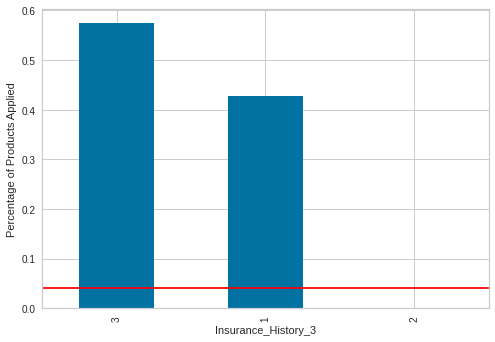

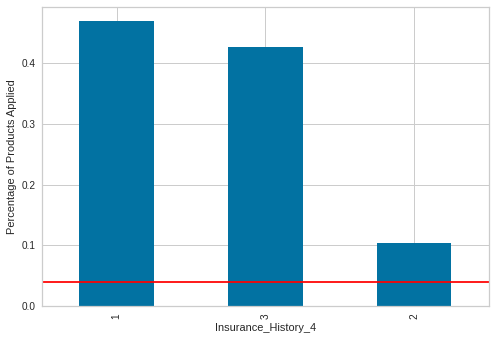

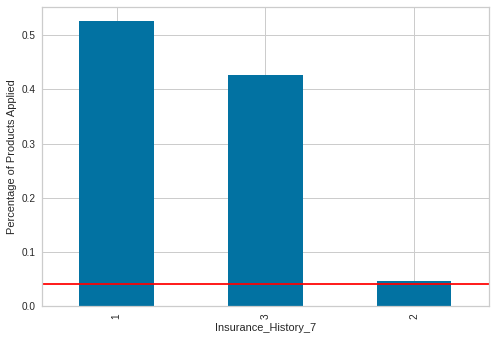

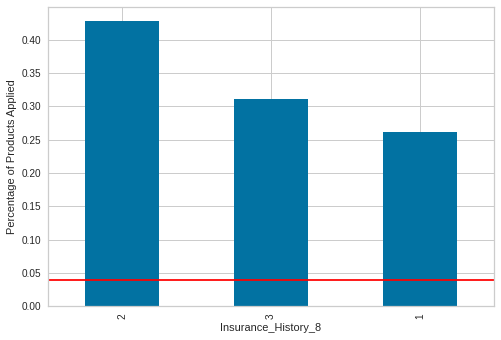

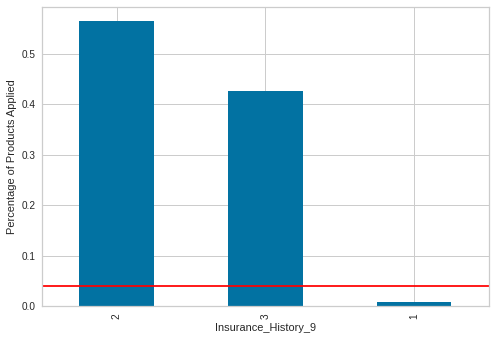

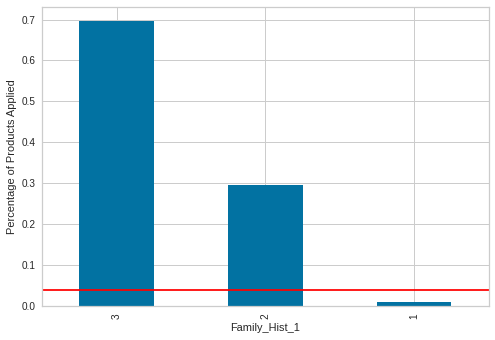

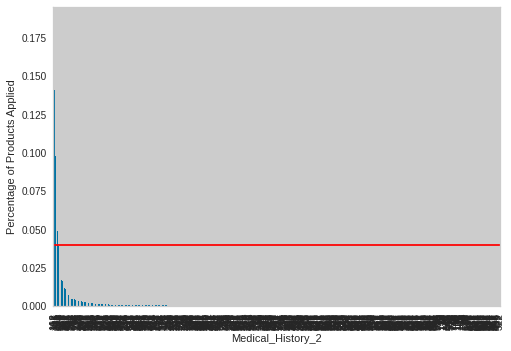

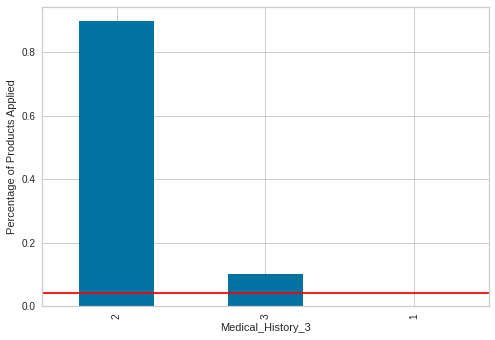

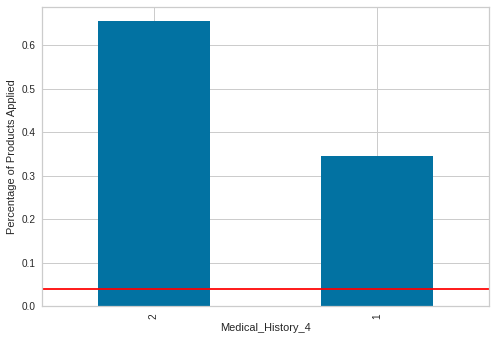

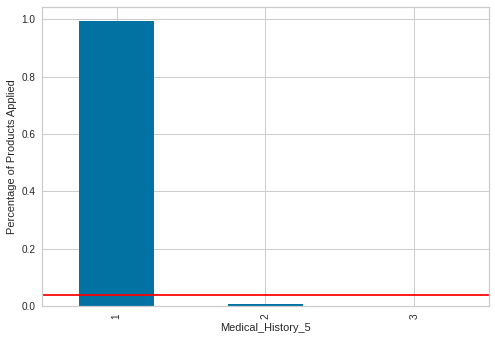

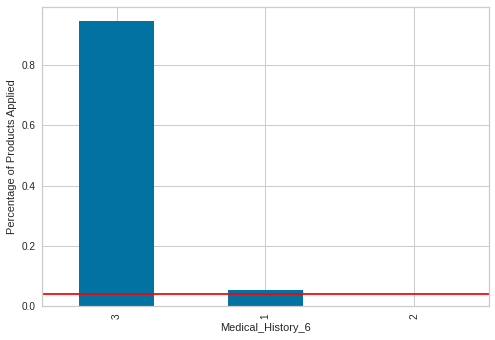

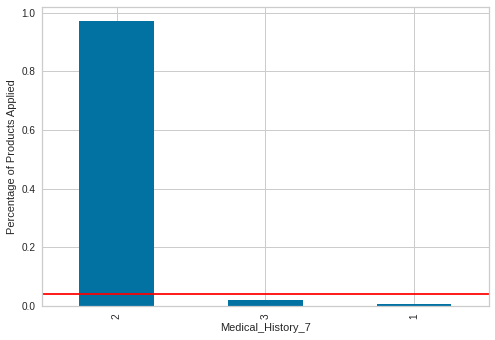

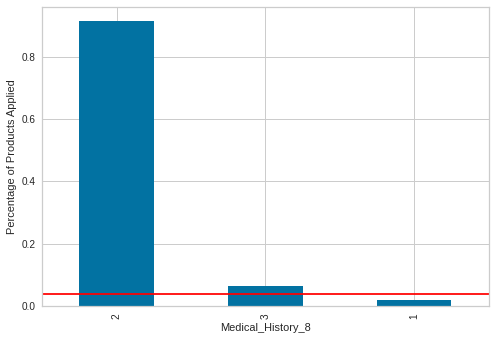

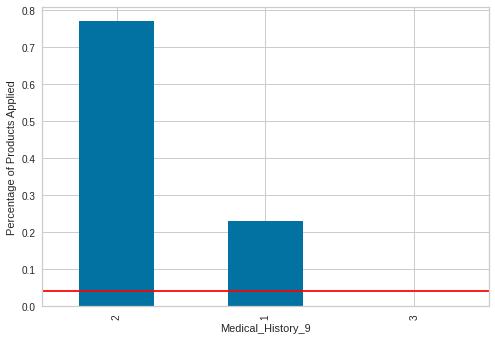

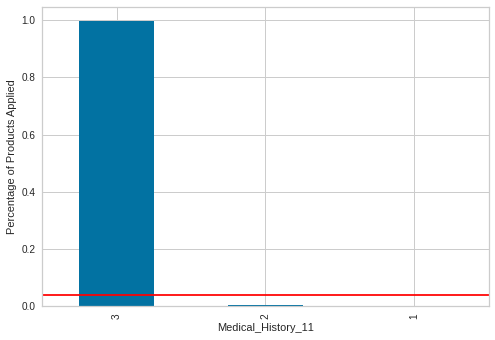

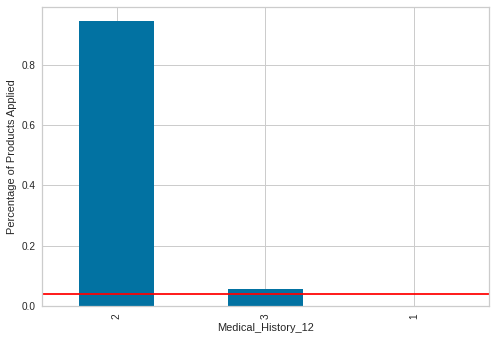

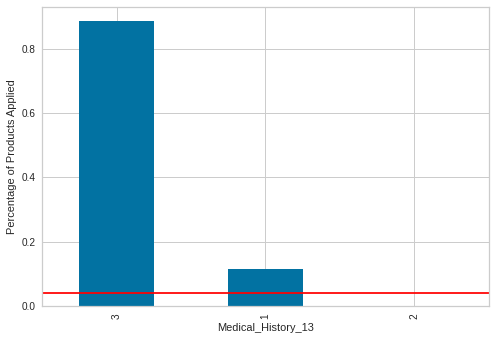

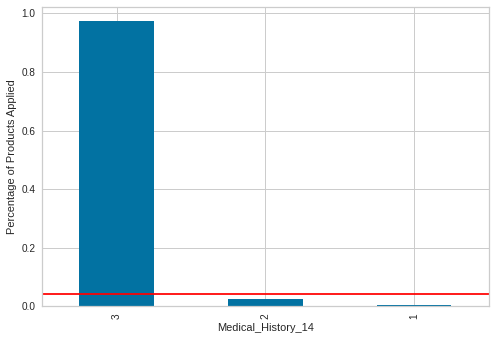

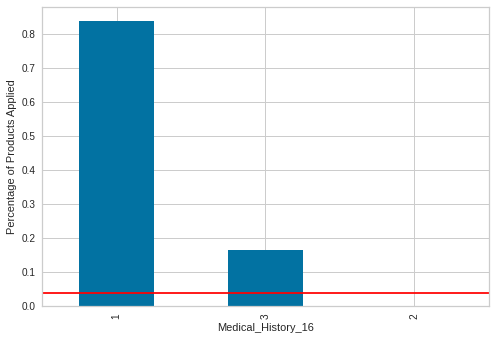

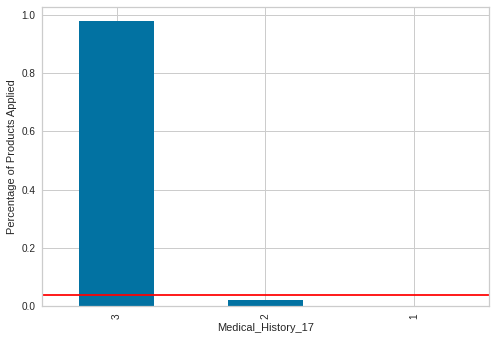

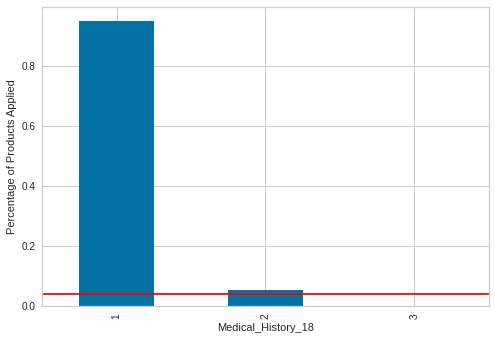

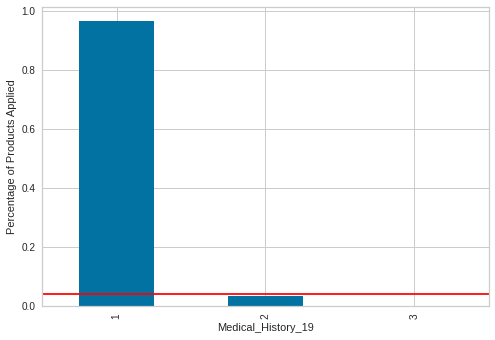

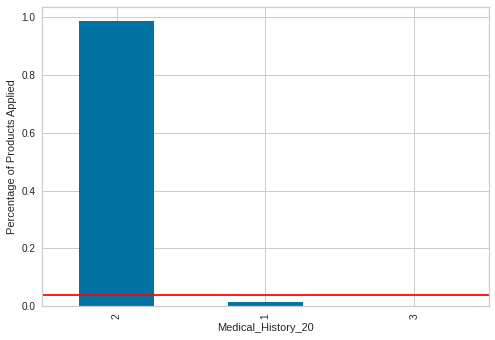

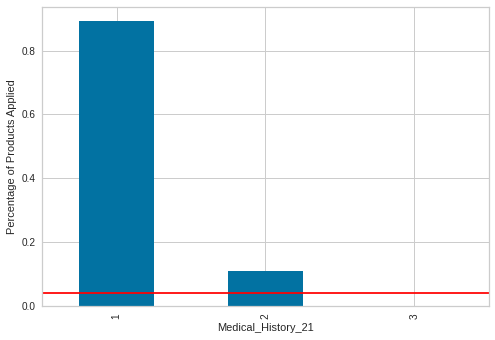

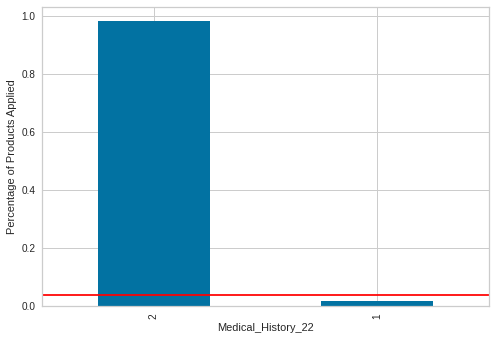

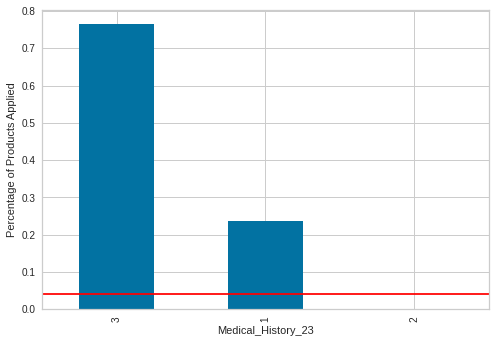

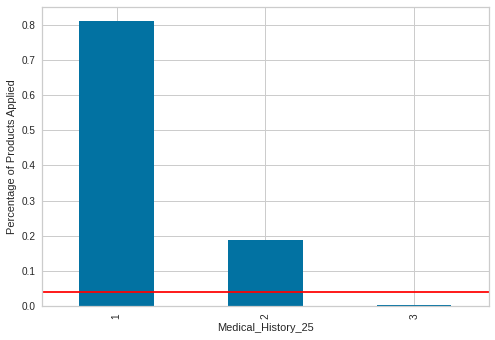

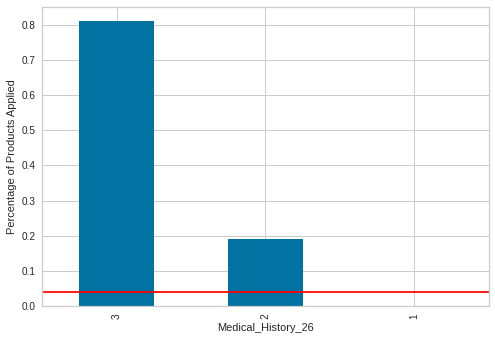

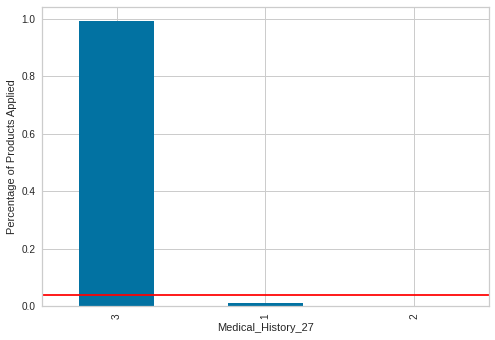

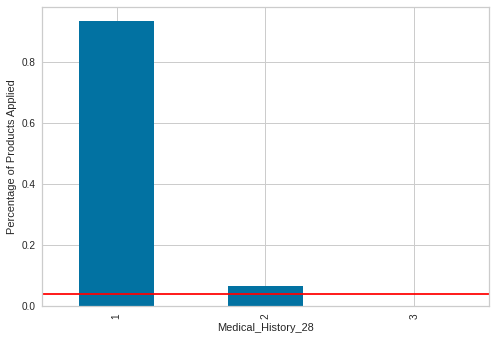

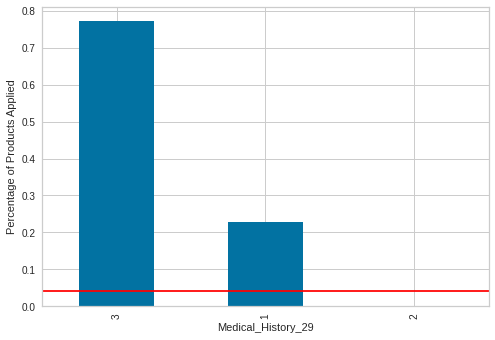

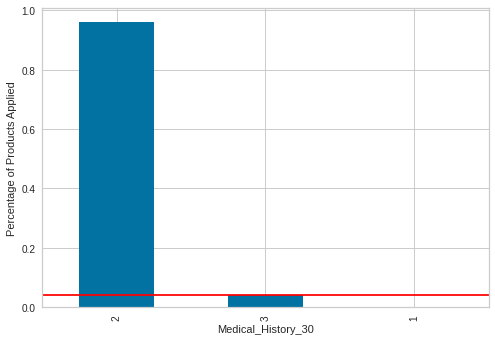

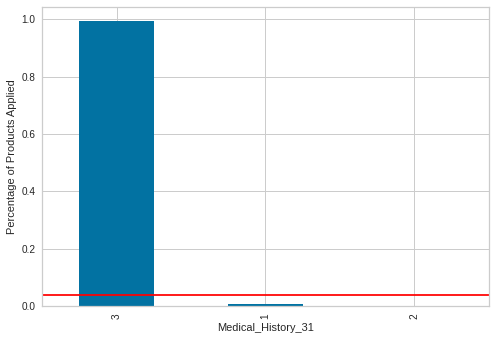

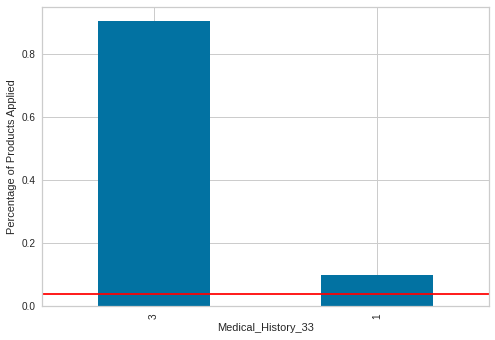

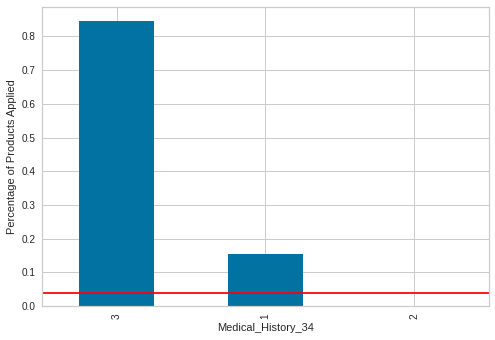

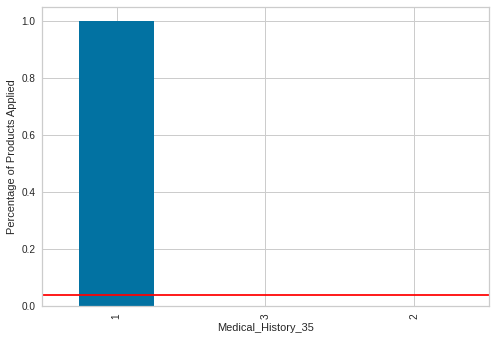

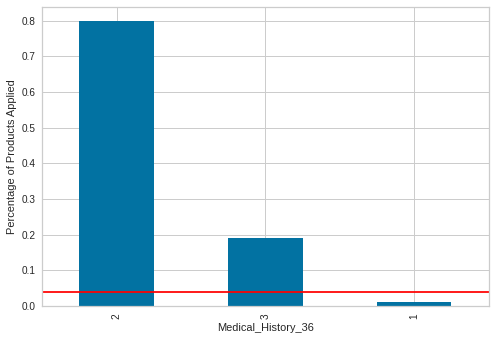

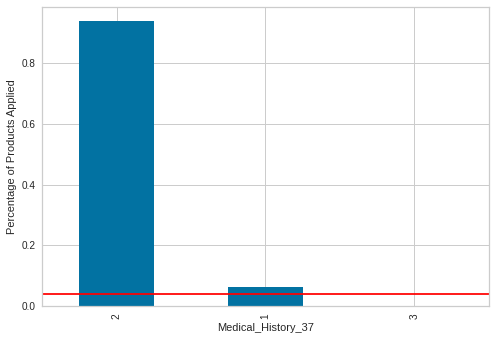

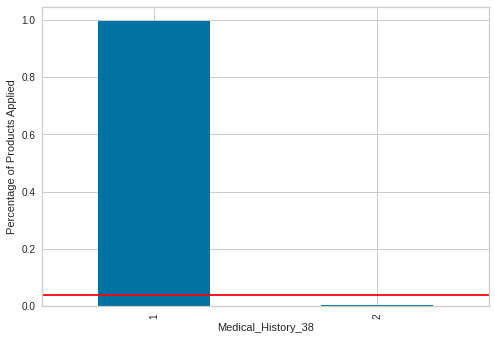

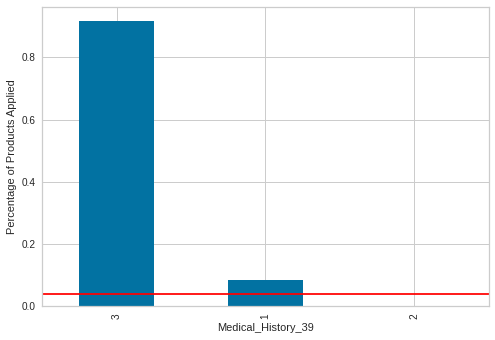

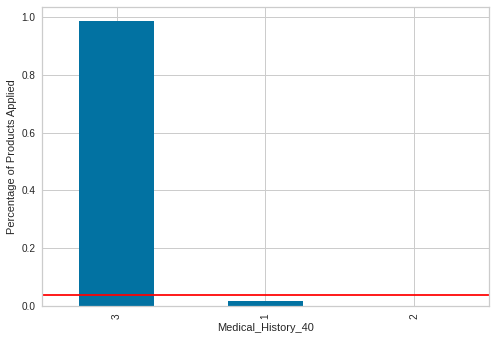

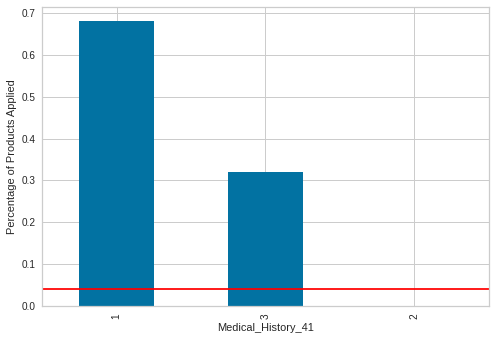

In [415]:
for col in lstCategorical:
    temp_df = pd.Series(train[col].value_counts() / len(train) )
    # make plot with the above percentages
    fig = temp_df.sort_values(ascending=False).plot.bar()
    fig.set_xlabel(col)

    # add a line at 5 % to flag the threshold for rare categories
    fig.axhline(y=0.04, color='red')
    fig.set_ylabel('Percentage of Products Applied')
    plt.show()

In [0]:
 train, test = rare_encoding(train, test, 'Product_Info_2', 0.05) #Due to high cardinality
 train, test = rare_encoding(train, test, 'Product_Info_3', 0.05) #Due to high cardinality
 train, test = rare_encoding(train, test, 'Employment_Info_2', 0.05) #Due to high cardinality
 train, test = rare_encoding(train, test, 'InsuredInfo_3', 0.05) #Due to high cardinality
 train, test = rare_encoding(train, test, 'Medical_History_2', 0.03) #Due to high cardinality

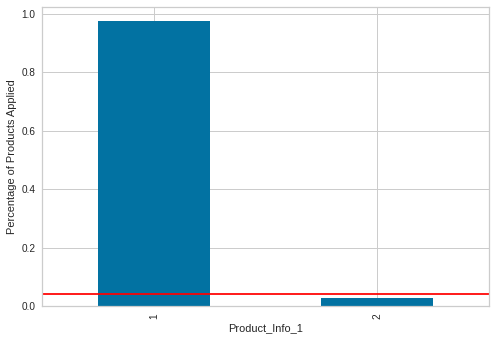

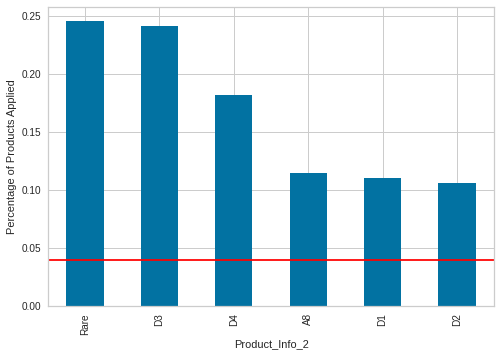

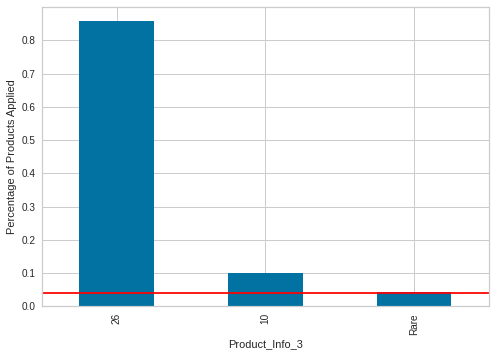

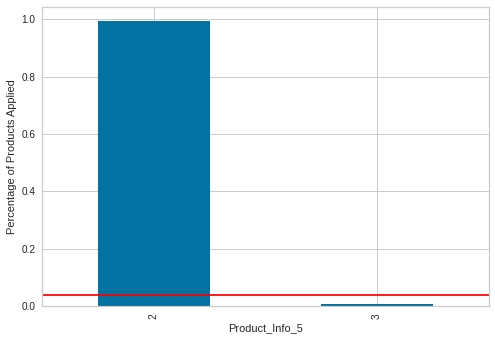

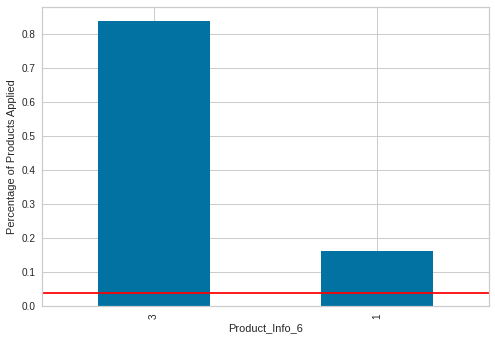

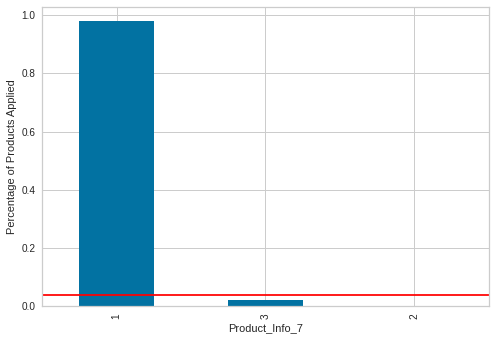

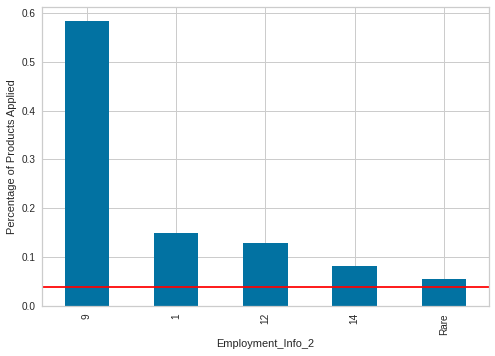

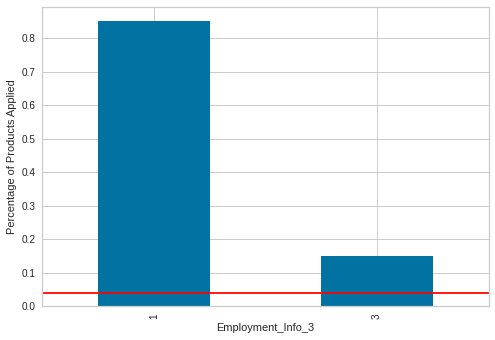

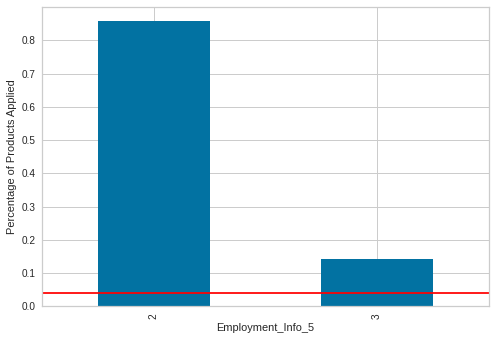

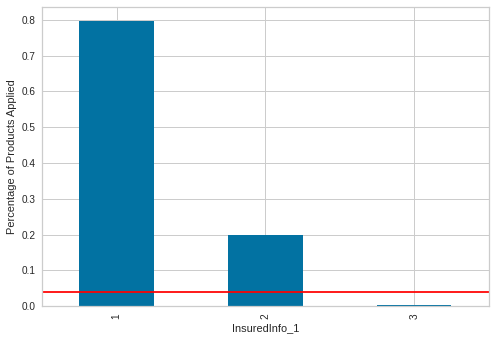

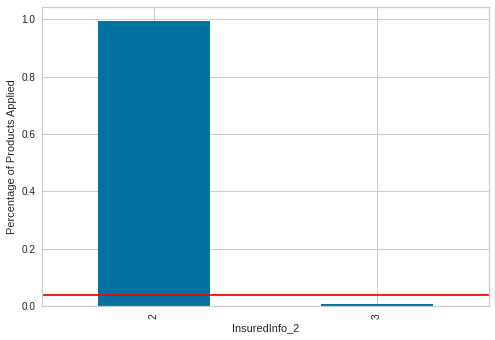

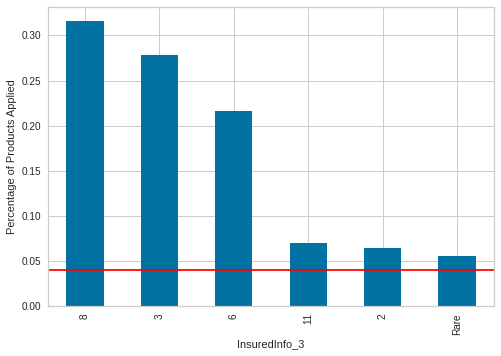

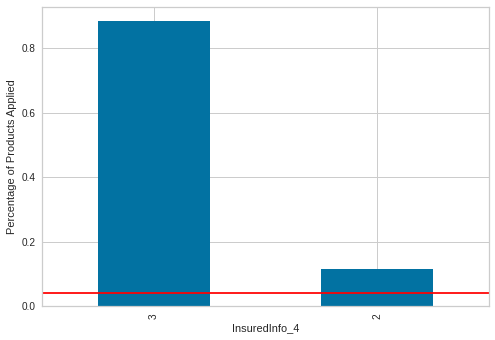

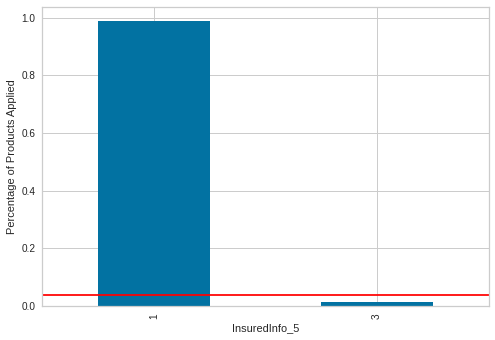

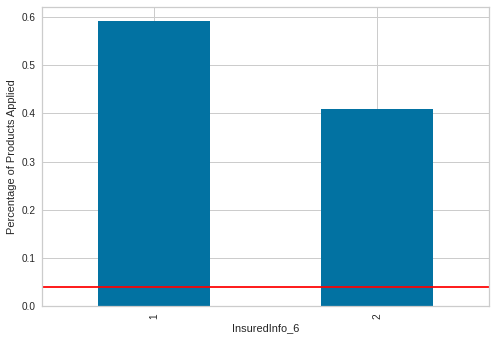

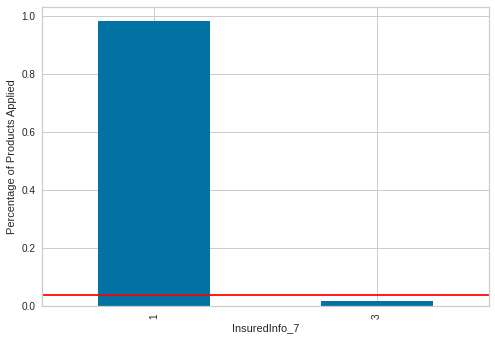

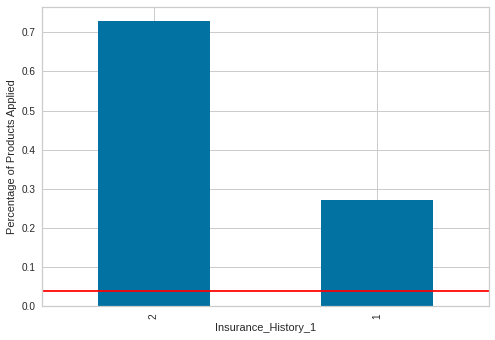

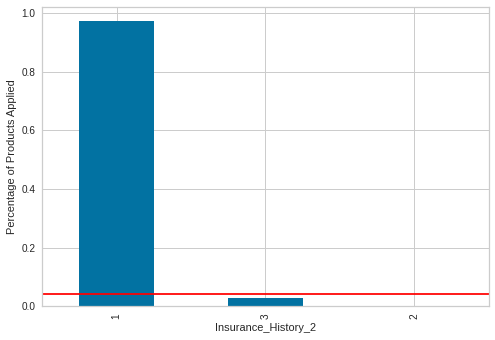

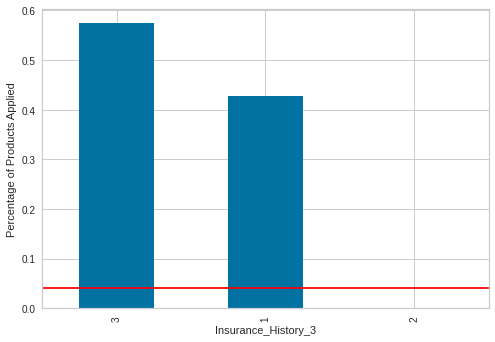

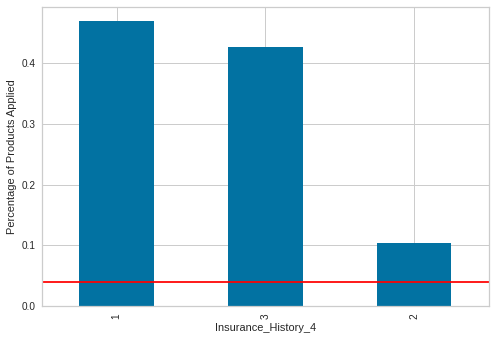

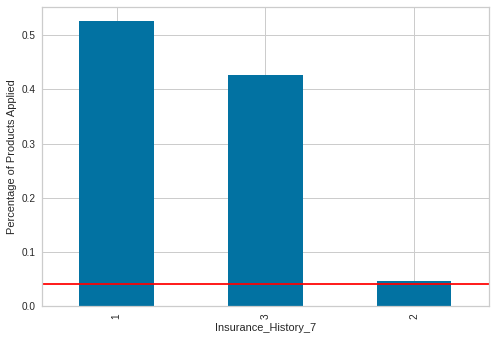

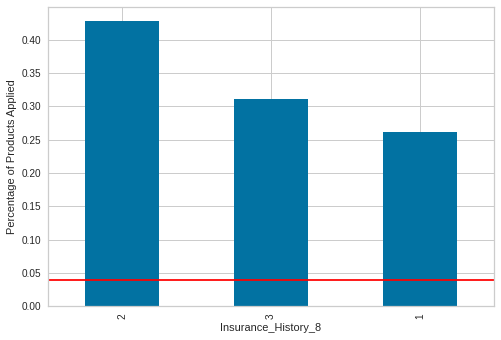

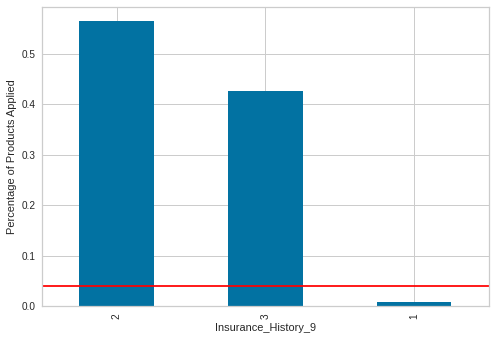

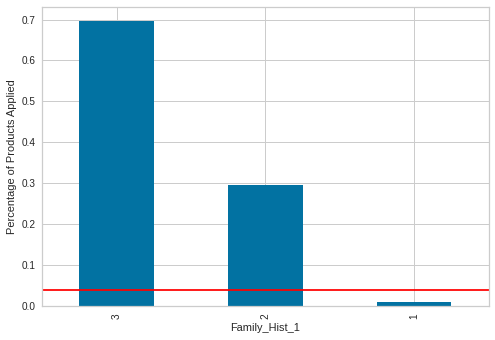

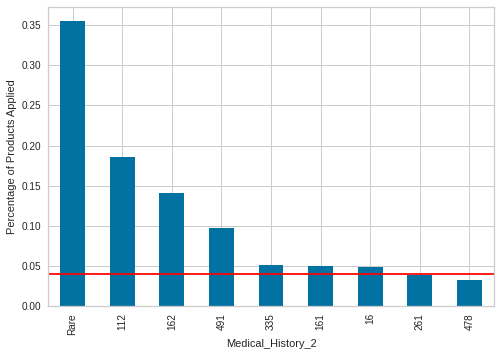

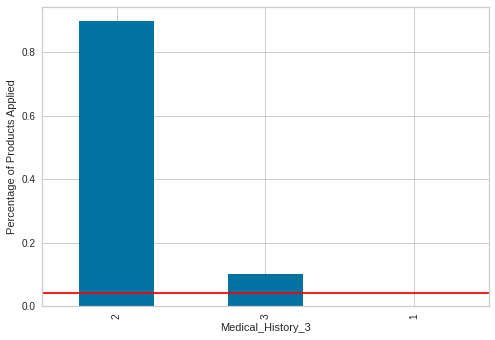

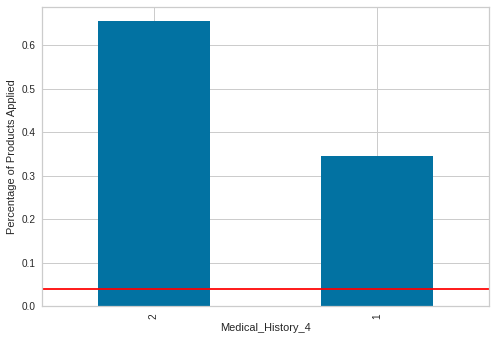

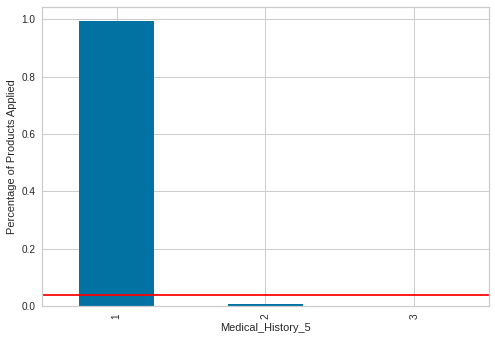

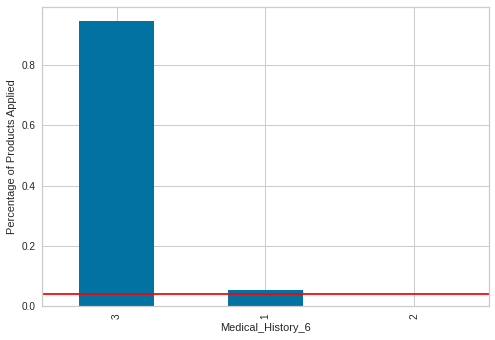

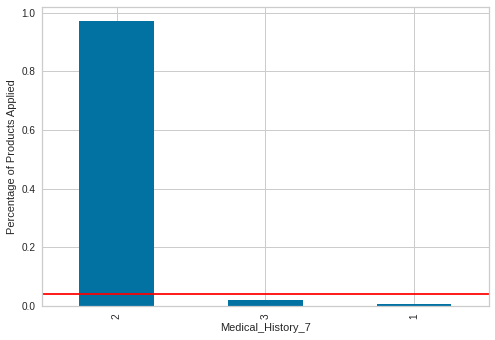

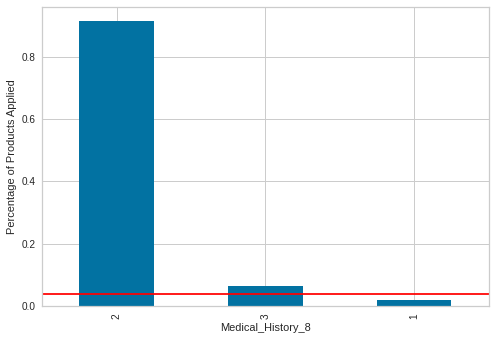

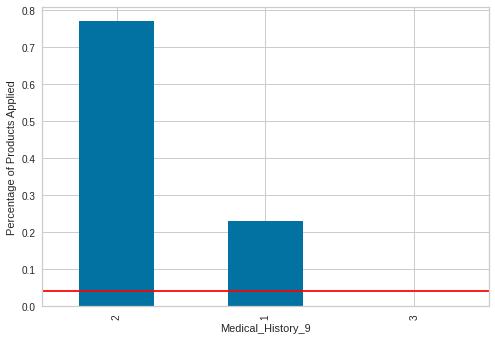

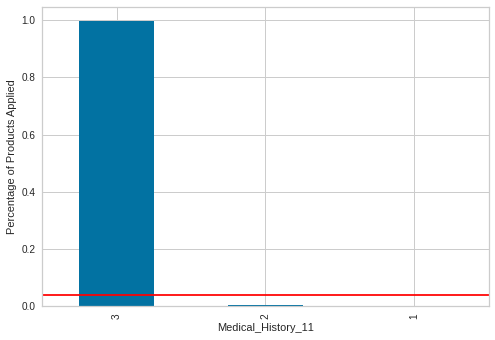

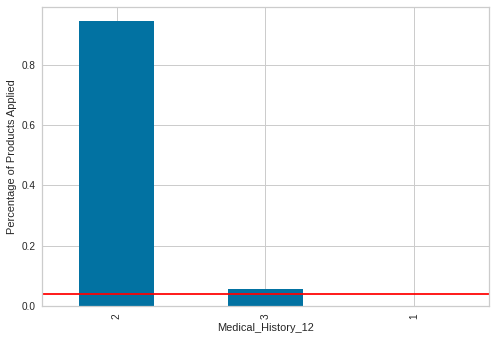

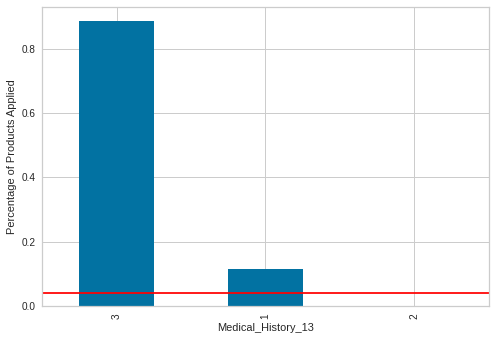

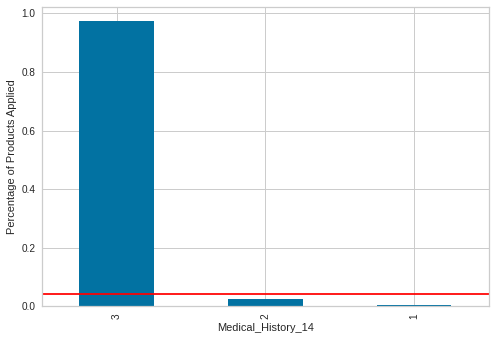

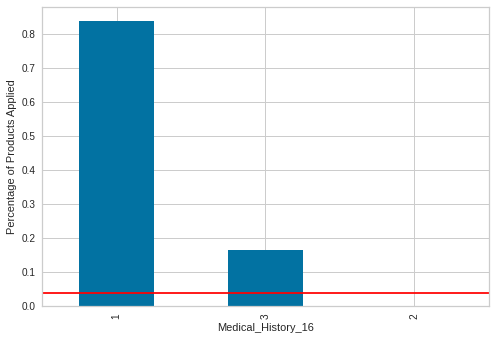

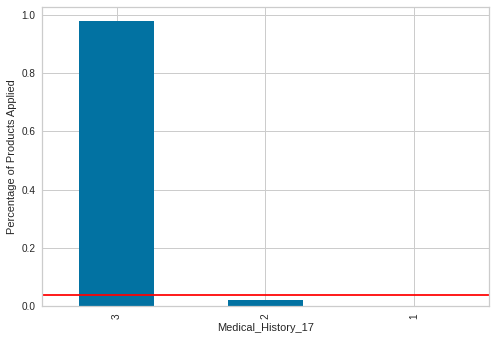

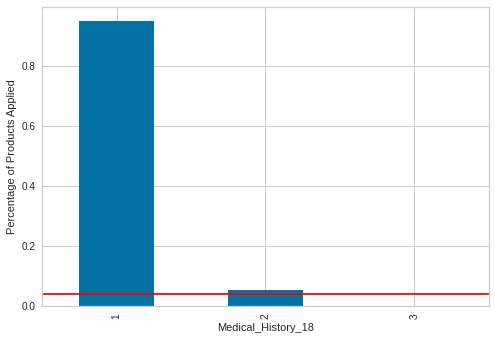

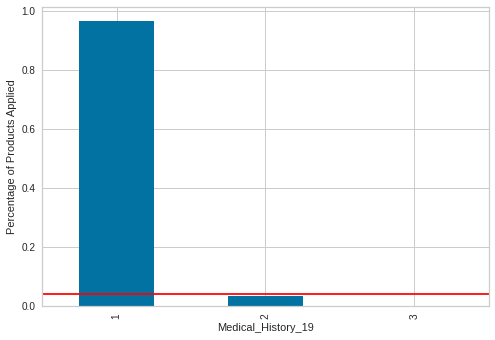

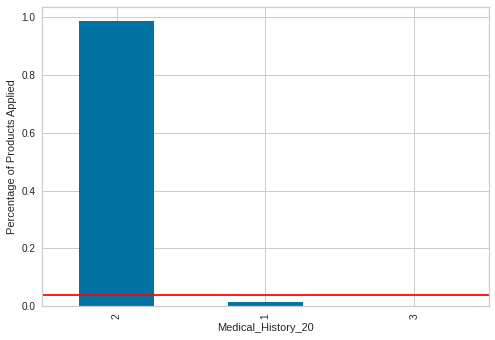

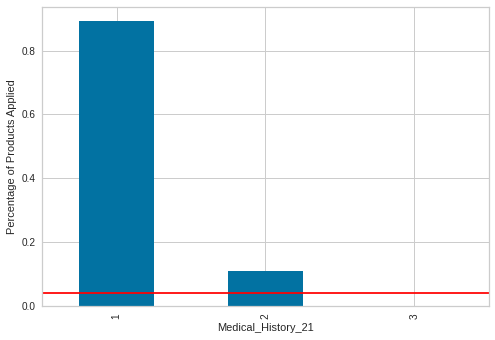

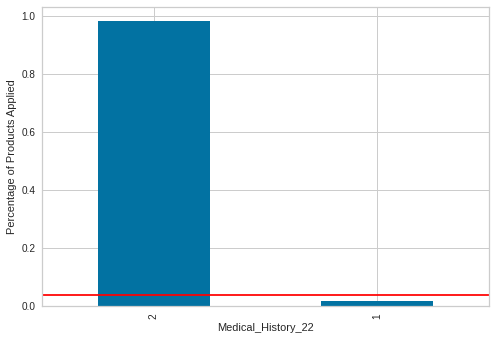

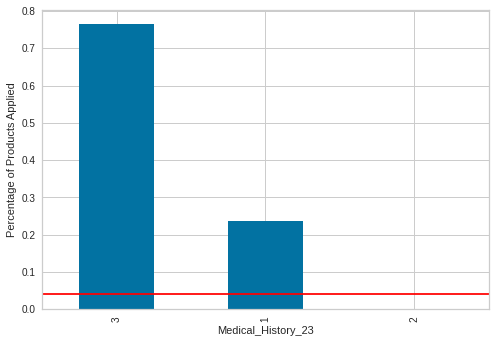

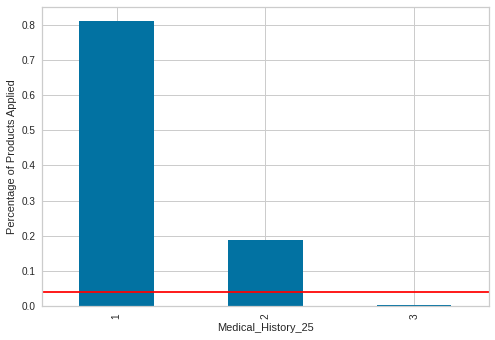

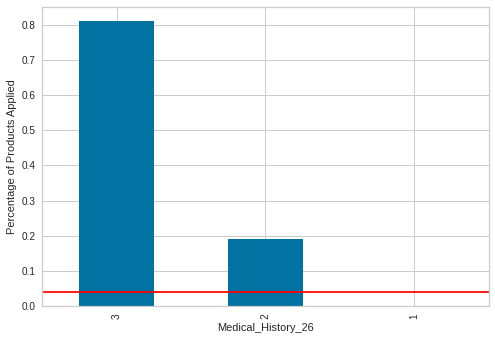

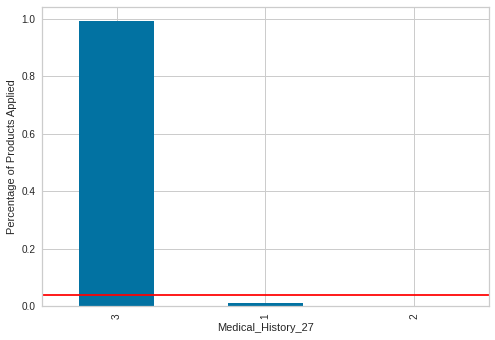

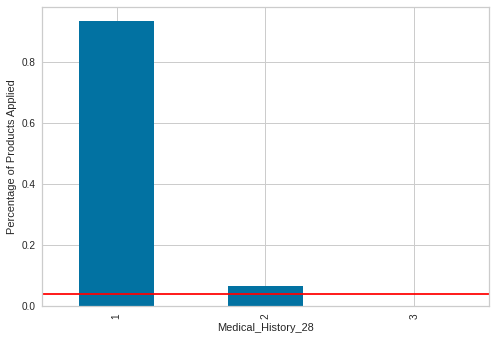

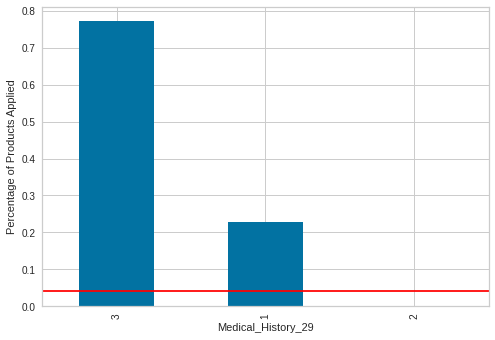

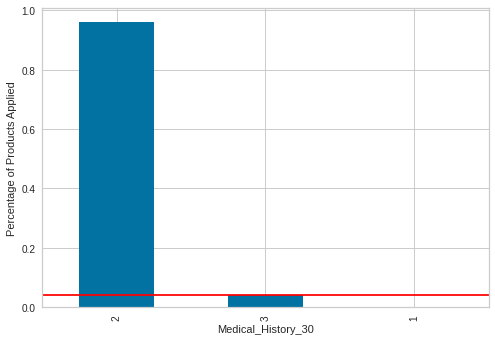

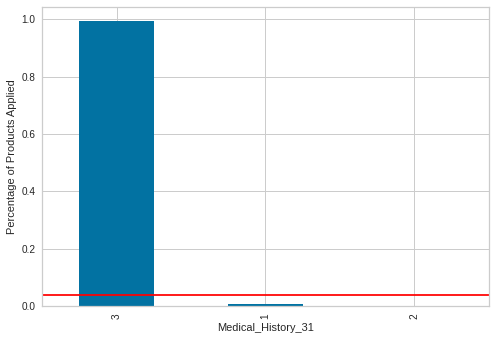

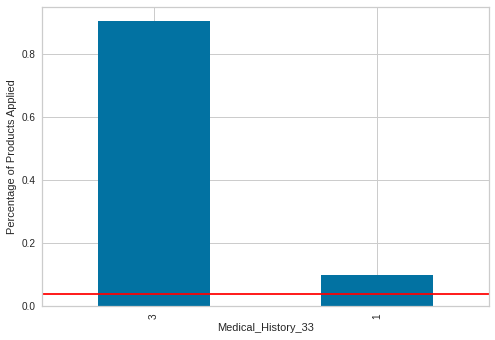

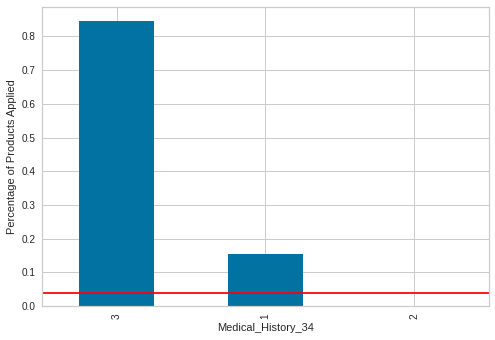

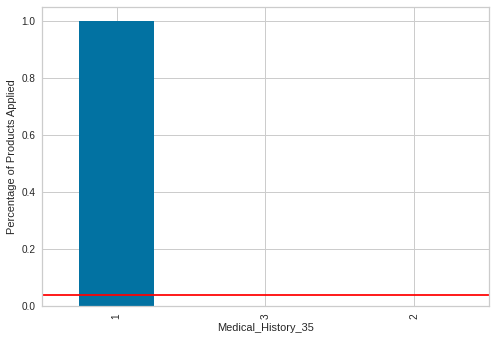

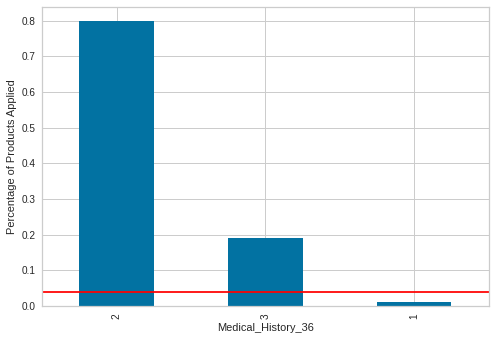

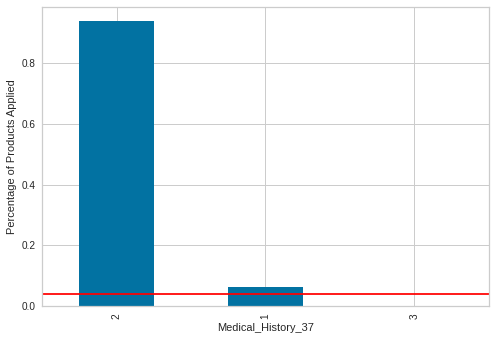

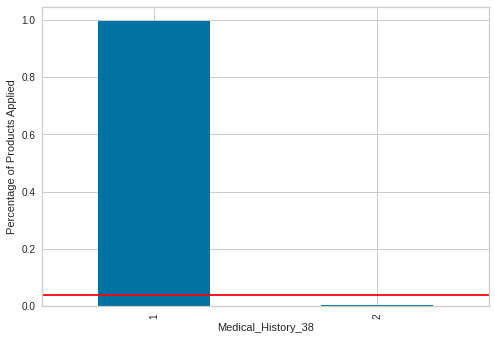

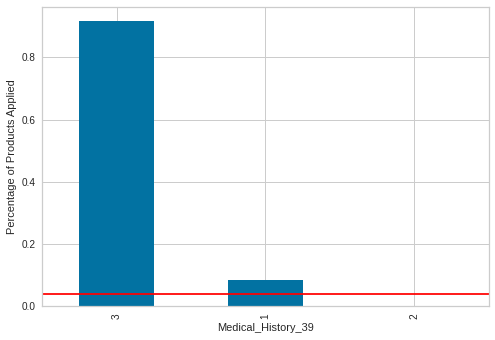

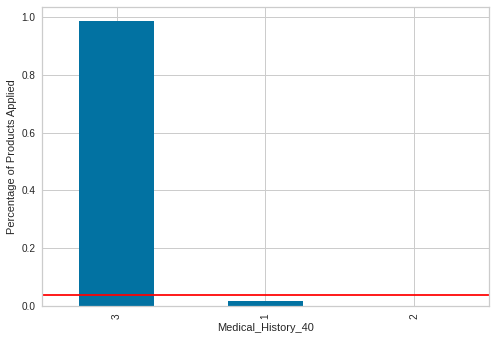

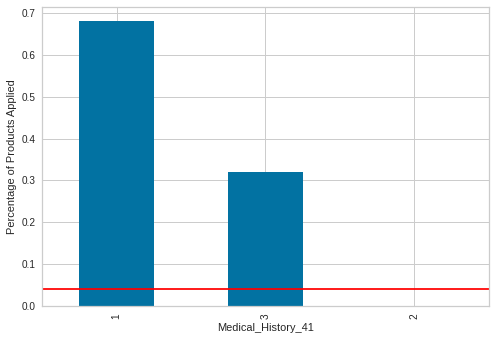

In [417]:
for col in lstCategorical:
    temp_df = pd.Series(train[col].value_counts() / len(train) )
    # make plot with the above percentages
    fig = temp_df.sort_values(ascending=False).plot.bar()
    fig.set_xlabel(col)

    # add a line at 5 % to flag the threshold for rare categories
    fig.axhline(y=0.04, color='red')
    fig.set_ylabel('Percentage of Products Applied')
    plt.show()

In [0]:
train[lstCategorical]=train[lstCategorical].apply(lambda x:x.astype('category').cat.codes)
test[lstCategorical]=test[lstCategorical].apply(lambda x:x.astype('category').cat.codes)


## **Selecting Categorical variables** ##

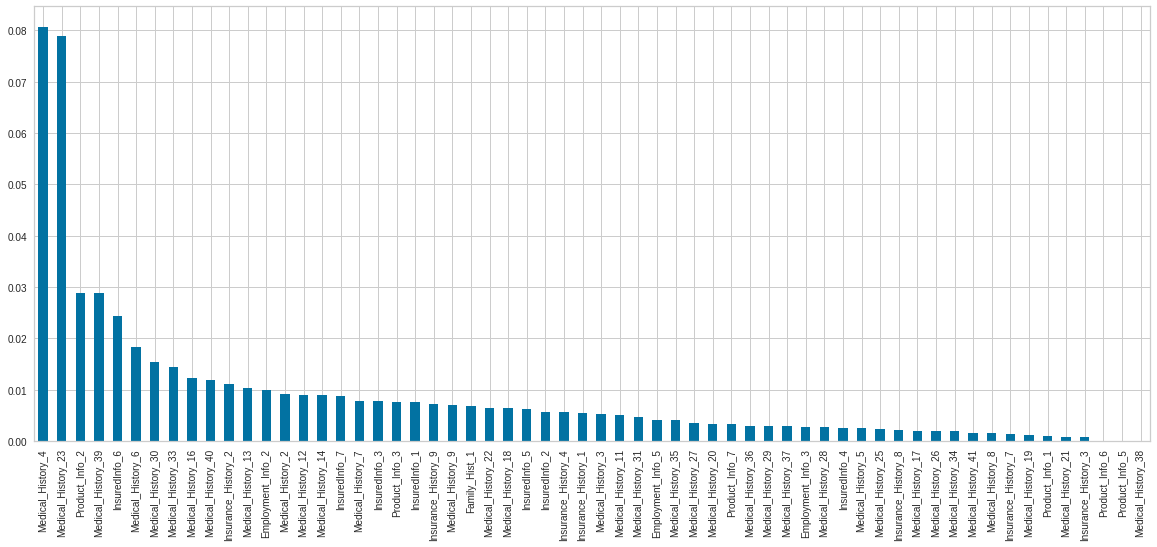

In [419]:
mi = mutual_info_classif(train.drop('Response',axis=1)[lstCategorical], train['Response'])
mi = pd.Series(mi)
mi.index = train.drop('Response' ,axis=1)[lstCategorical].columns
mi.sort_values(ascending=False)
mi.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [0]:
sel_ = SelectKBest(mutual_info_classif, k=14).fit(train[lstCategorical], train['Response'])
selectedCatColumns=train[lstCategorical].columns[sel_.get_support()]

In [421]:
selectedCatColumns

Index(['Product_Info_2', 'Employment_Info_2', 'Employment_Info_3',
       'InsuredInfo_6', 'Medical_History_2', 'Medical_History_4',
       'Medical_History_6', 'Medical_History_13', 'Medical_History_16',
       'Medical_History_23', 'Medical_History_30', 'Medical_History_33',
       'Medical_History_39', 'Medical_History_40'],
      dtype='object')

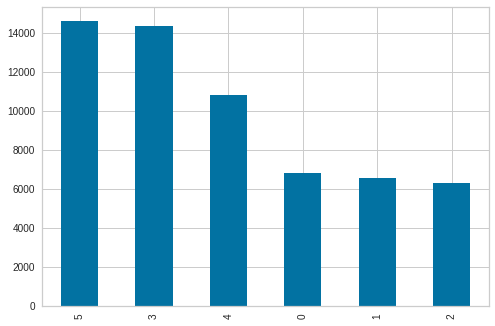

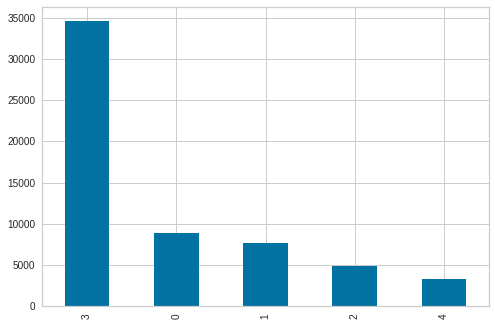

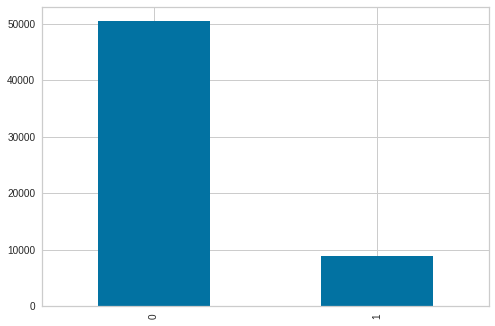

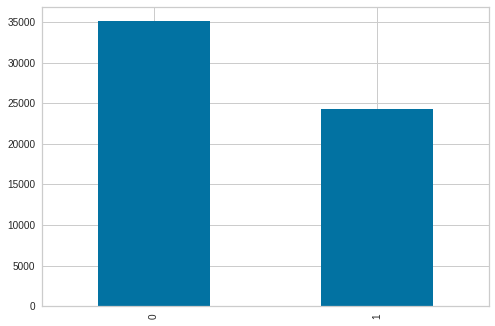

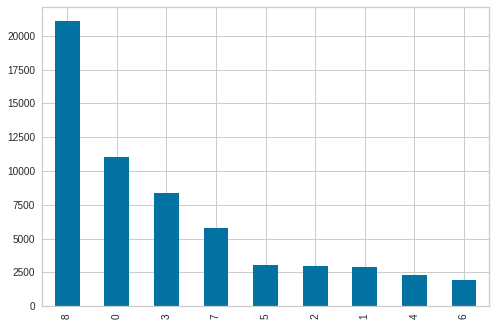

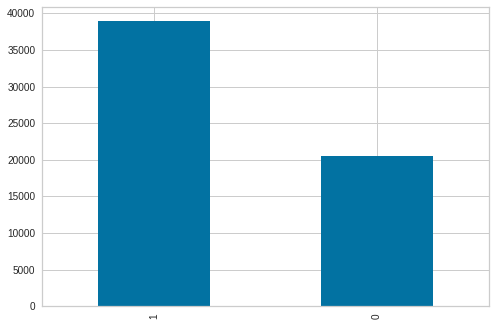

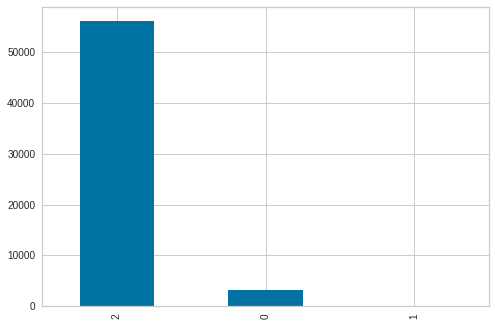

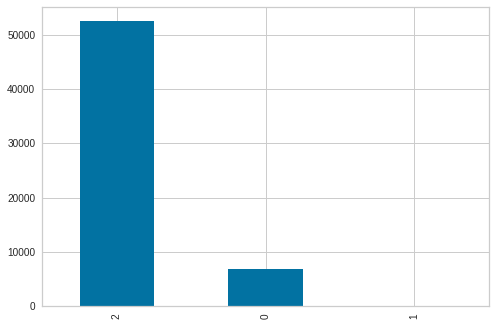

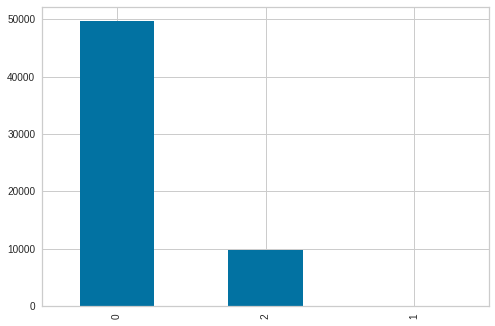

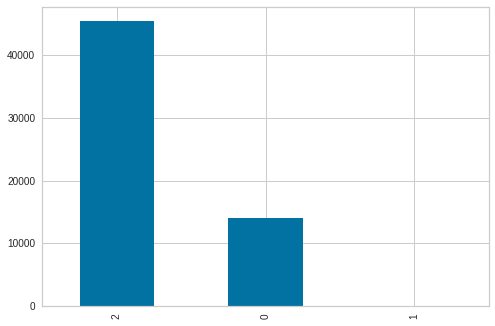

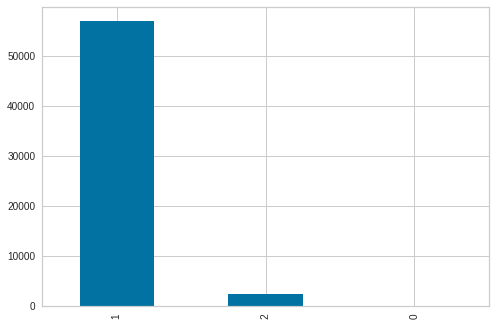

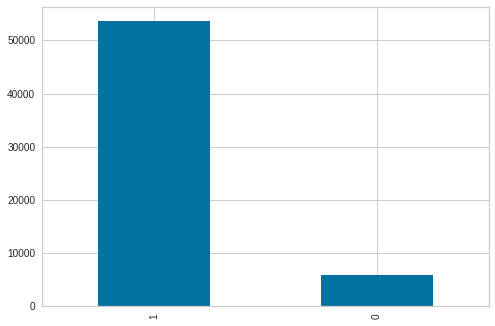

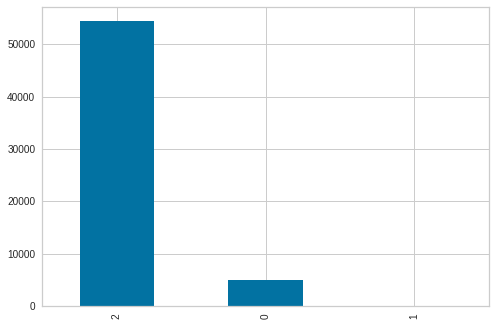

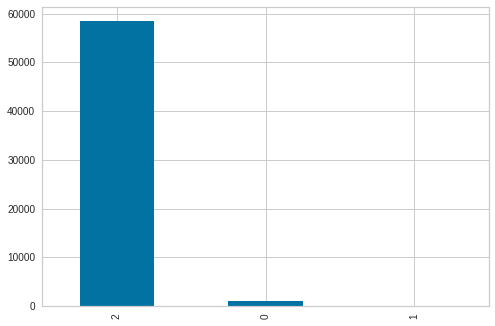

In [422]:
for col in selectedCatColumns:
  train[col].value_counts().plot(kind='bar')
  plt.show()

['Medical_History_1', 'Medical_Keyword_1', 'Product_Info_4', 'Ins_Age', 'Ht', 'Wt', 'BMI', 'Employment_Info_1']


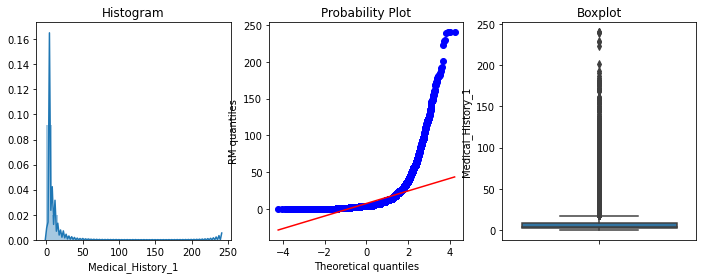

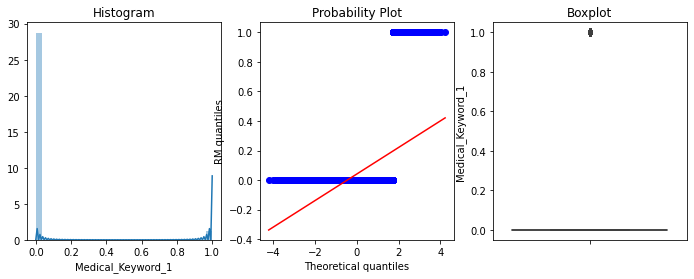

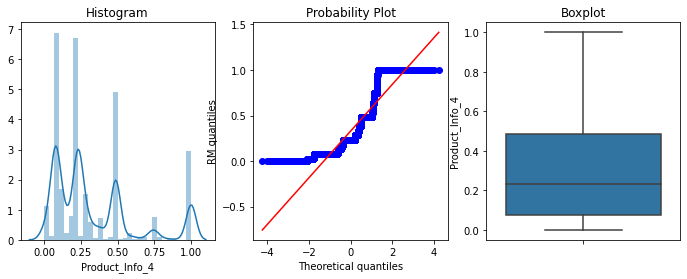

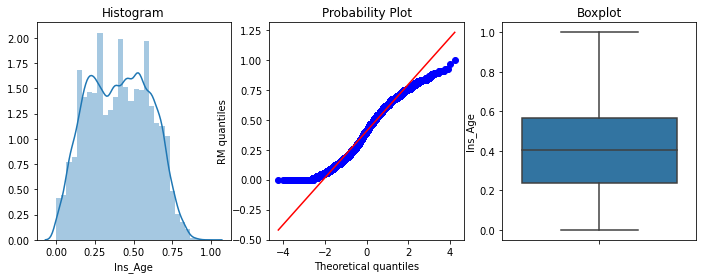

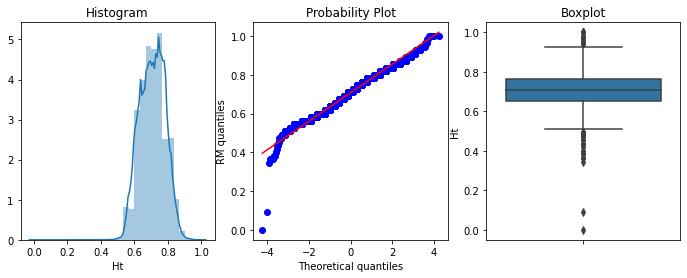

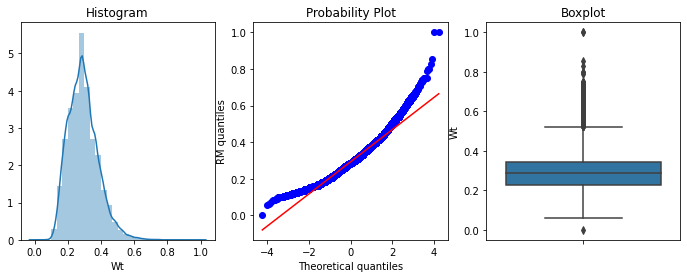

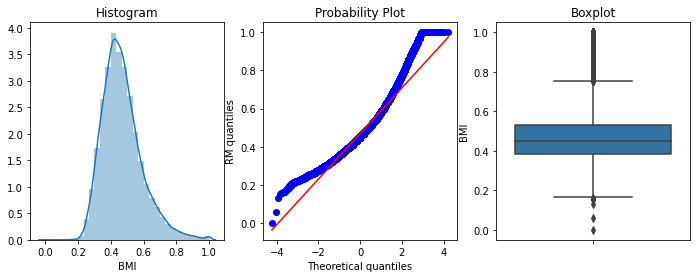

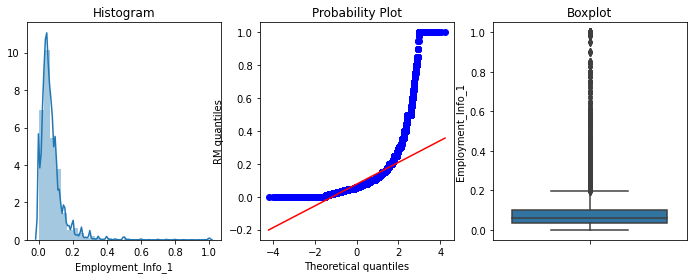

In [81]:
numerical=lstDiscrete+lstContinuous
print(numerical)
for col in numerical:
  diagnostic_plots(train,col)

## **Preprocessing Numeric Variables**

In [0]:


train['BMI_LOG']=train['BMI'].apply(lambda x: np.log(x+1))
test['BMI_LOG']=test['BMI'].apply(lambda x: np.log(x+1))


train['Ins_Age_exp']=train['Ins_Age'].apply(lambda x:  x**(1/1.2))
test['Ins_Age_exp']=test['Ins_Age'].apply(lambda x:  x**(1/1.2))


train['Wt_LOG']=train['Wt'].apply(lambda x: np.log(x+1))
test['Wt_LOG']=test['Wt'].apply(lambda x: np.log(x+1))


train['Medical_History_1_LOG']=train['Medical_History_1'].apply(lambda x: np.log(x+1))
test['Medical_History_1_LOG']=test['Medical_History_1'].apply(lambda x: np.log(x+1))

train=train.drop(['BMI','Ins_Age','Wt','Medical_History_1'],axis=1)
test=test.drop(['BMI','Ins_Age','Wt','Medical_History_1'],axis=1)

**No Significant Observation for Employement_Info_1**

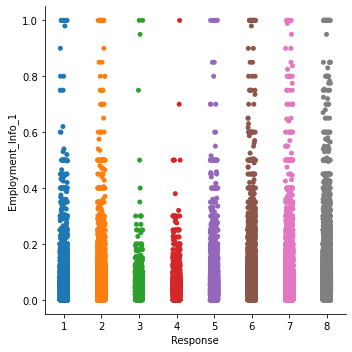

In [123]:

sns.catplot(x="Response", y='Employment_Info_1', data=train);



In [0]:
windsoriser = Winsorizer(distribution='quantiles', 
                          tail='right', # cap left, right or both tails 
                          fold=3,
                          variables=['Employment_Info_1'])

windsoriser.fit(train.drop('Response',axis=1))
train_t=windsoriser.transform(train.drop('Response',axis=1))
test=windsoriser.transform(test)
train_t['Response']=train['Response']
train=train_t

## **Train-Test-Split Stratified Sampling**##

In [486]:
train['BMI_Age'] = train['BMI_LOG'] * train['Ins_Age_exp']
test['BMI_Age'] = test['BMI_LOG'] * test['Ins_Age_exp']

cols=lstContinuous+lstDiscrete+list(selectedCatColumns)+['BMI_Age','Response','BMI_LOG','Ins_Age_exp','Wt_LOG','Medical_History_1_LOG']
removedCols=['Medical_History_1', 'Ins_Age', 'BMI', 'Wt']

newCols = [ele for ele in cols if ele not in removedCols] 

testColumns=newCols
testColumns.remove('Response')
test=test[testColumns]

X_train, X_test, y_train, y_test = train_test_split(
    train[testColumns],
    train['Response'],
    test_size=0.3,
    stratify=train['Response'],
    random_state=0)

X_train.shape, X_test.shape


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


((41566, 23), (17815, 23))

**No Significant Obsercation for Ins_Age vs Response**

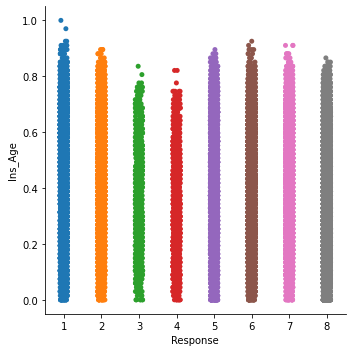

In [18]:
#No signifcation O

sns.catplot(x="Response", y="Ins_Age", data=train);

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:324: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


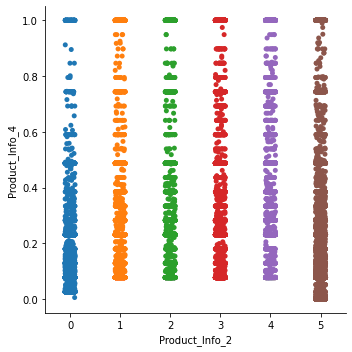

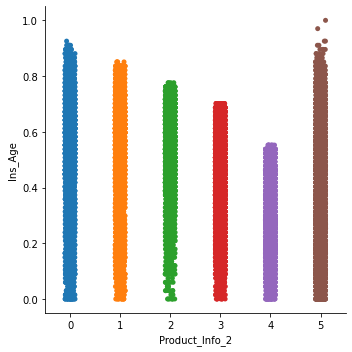

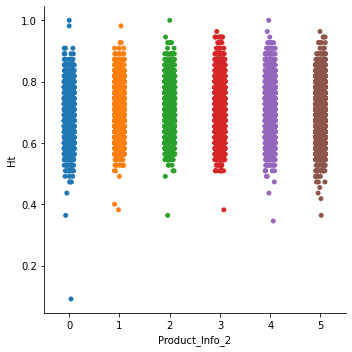

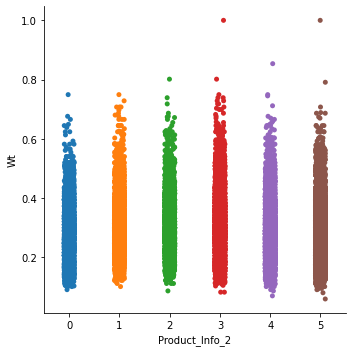

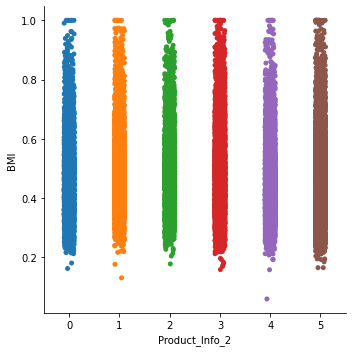

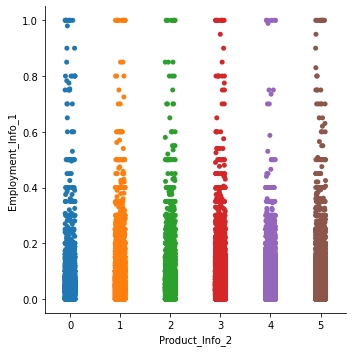

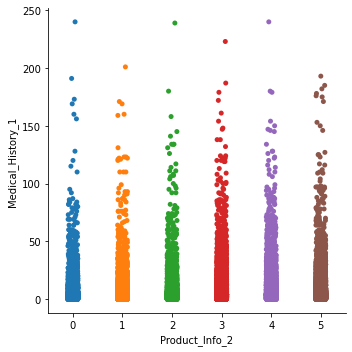

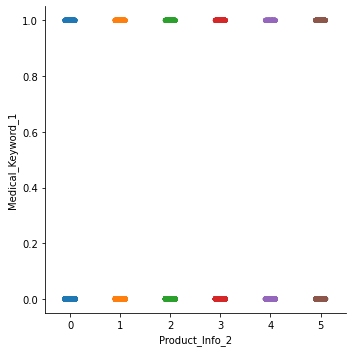

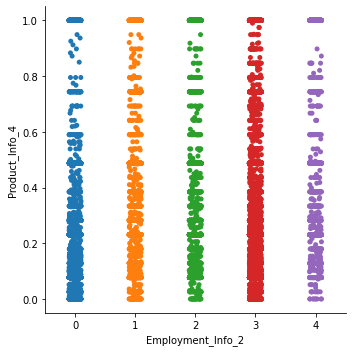

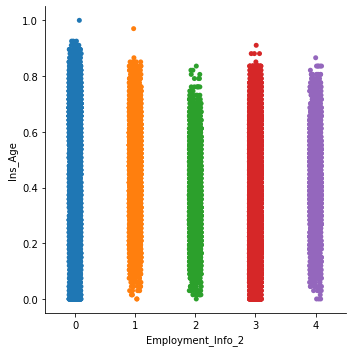

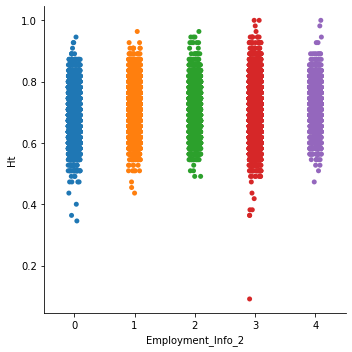

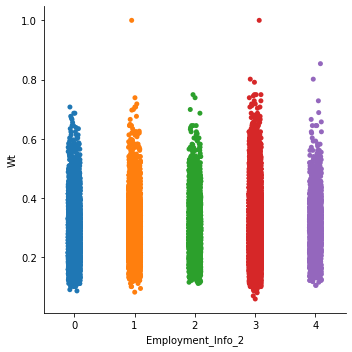

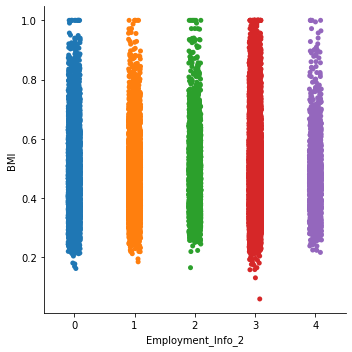

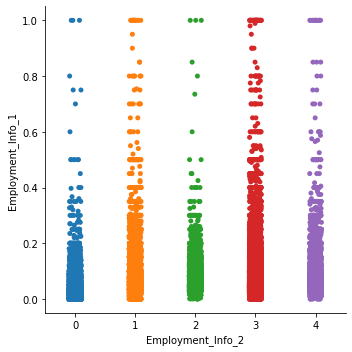

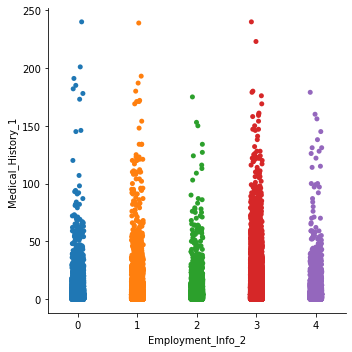

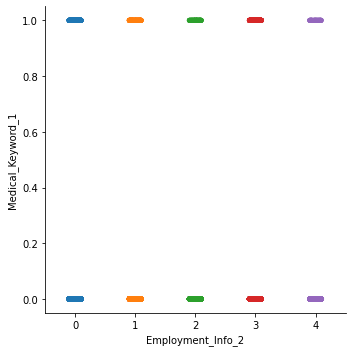

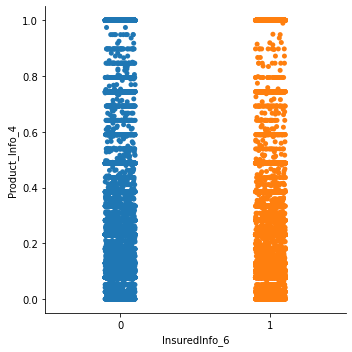

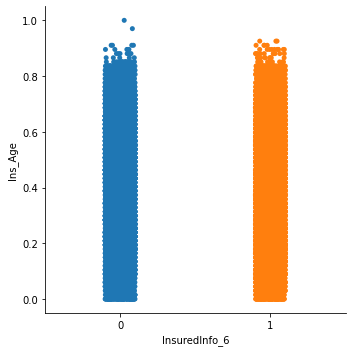

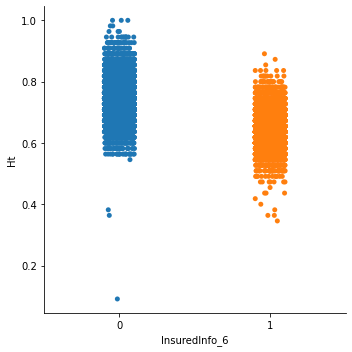

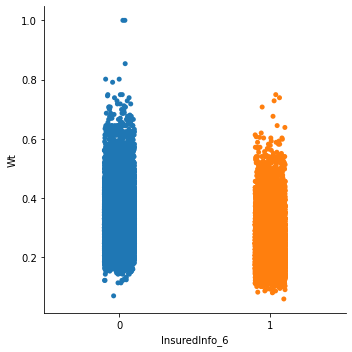

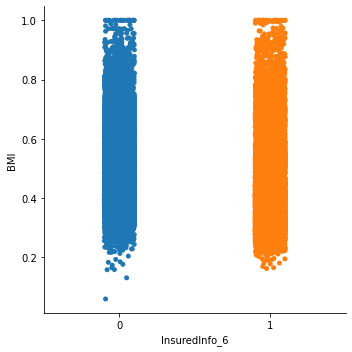

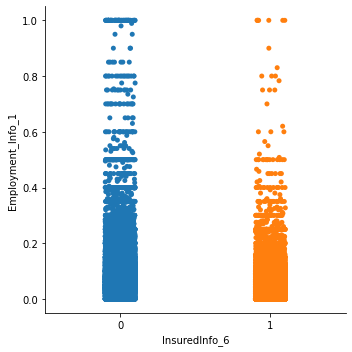

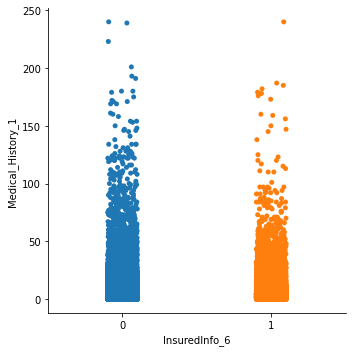

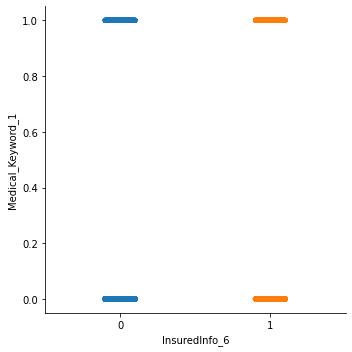

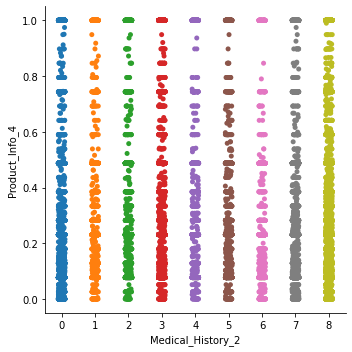

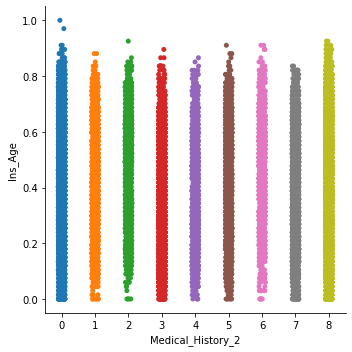

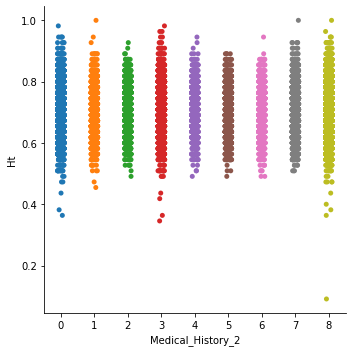

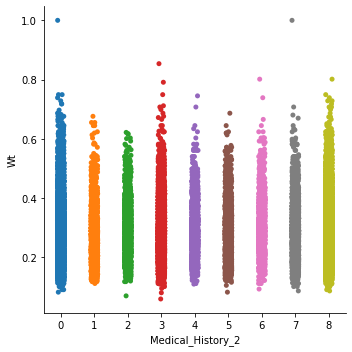

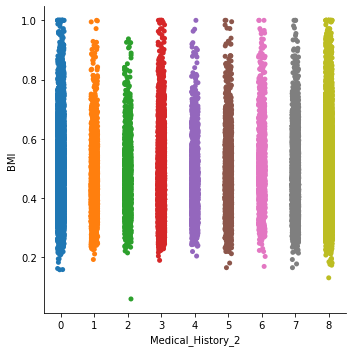

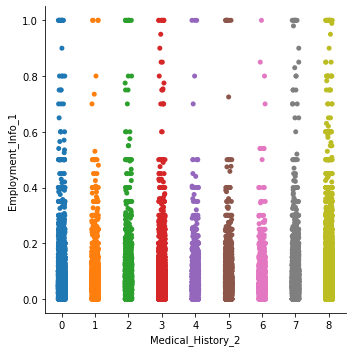

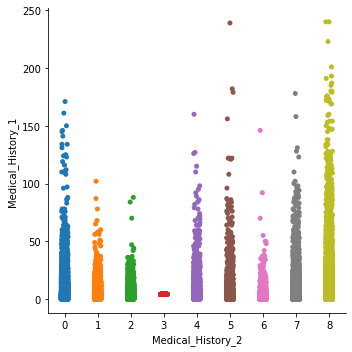

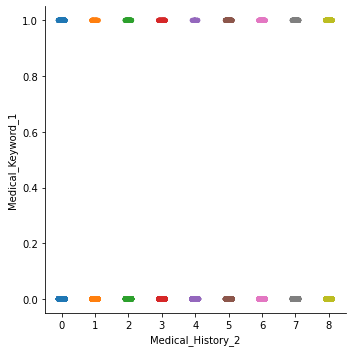

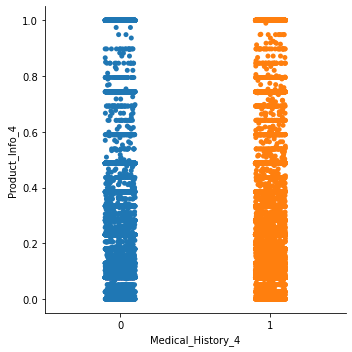

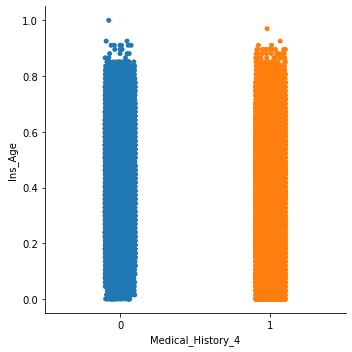

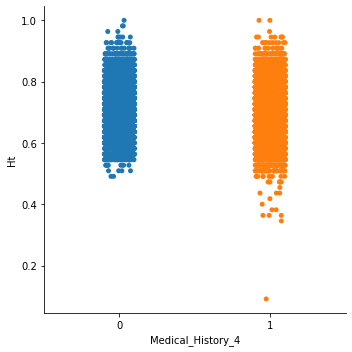

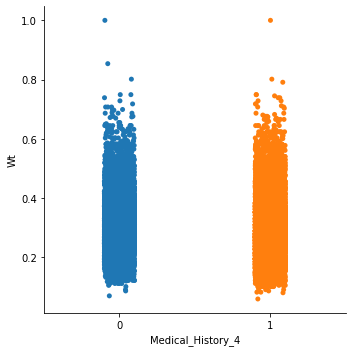

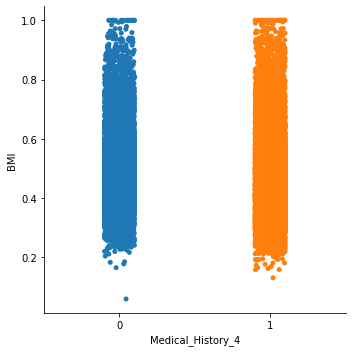

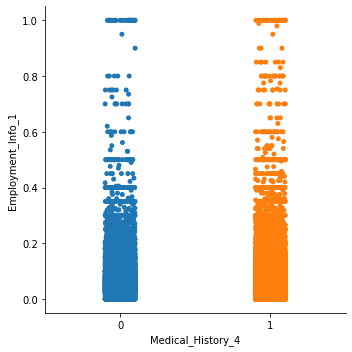

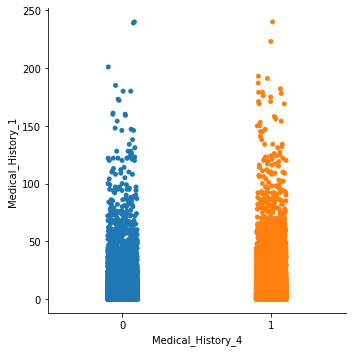

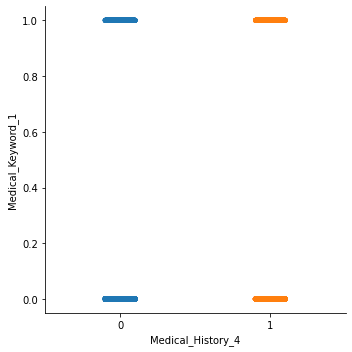

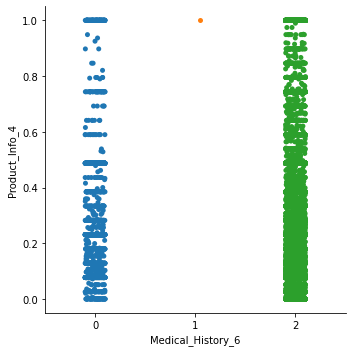

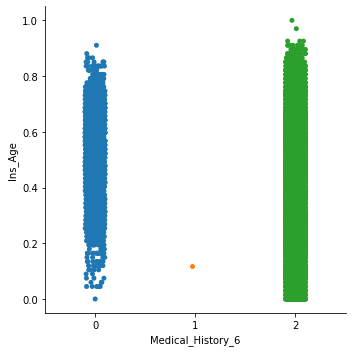

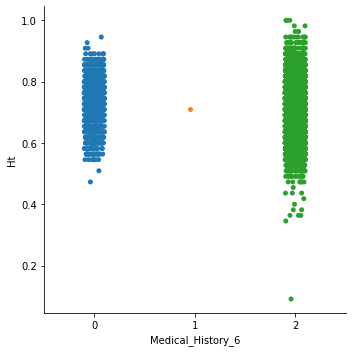

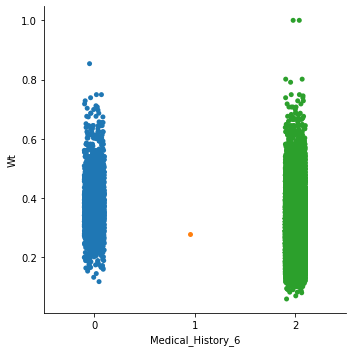

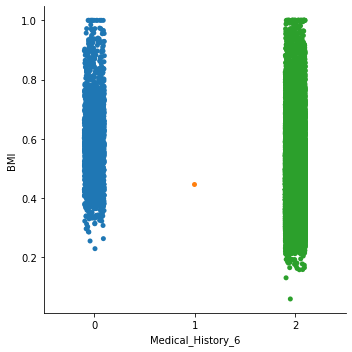

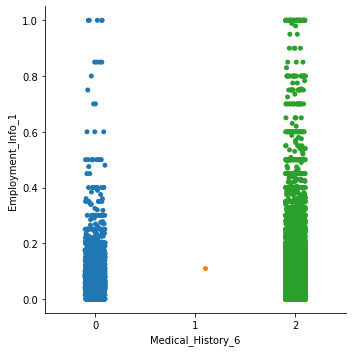

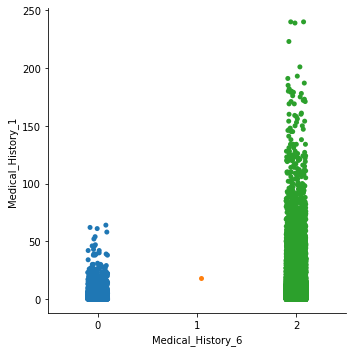

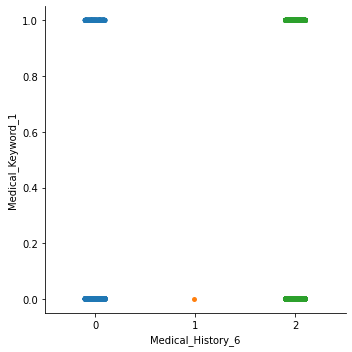

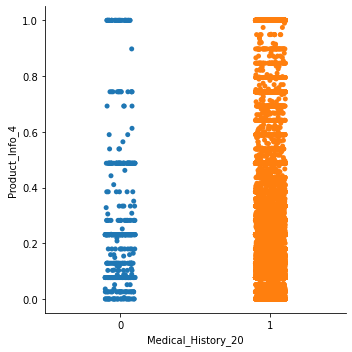

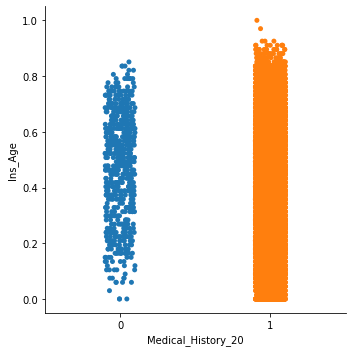

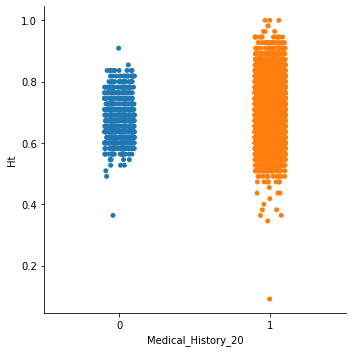

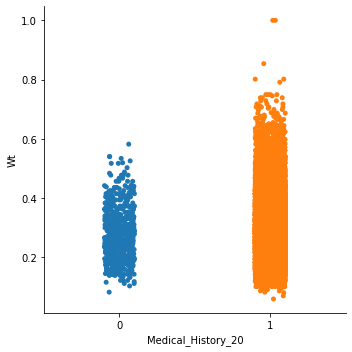

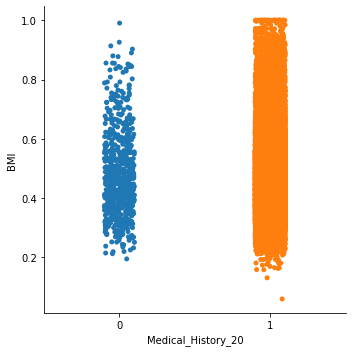

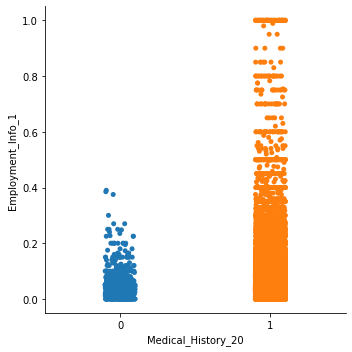

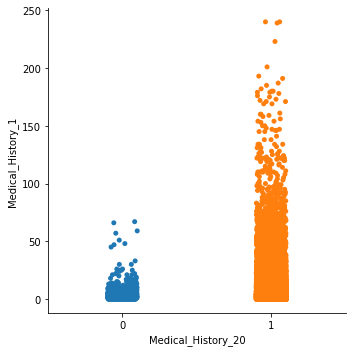

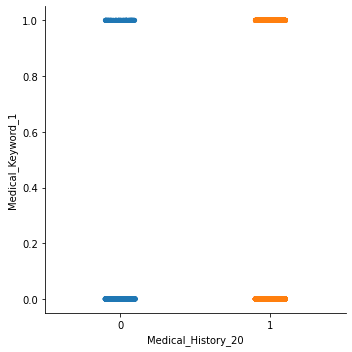

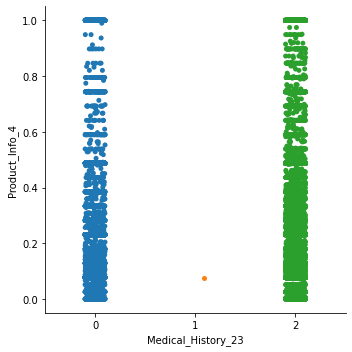

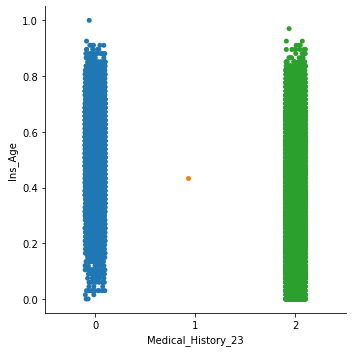

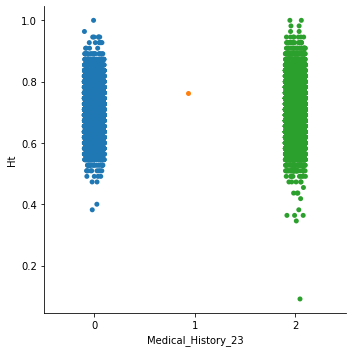

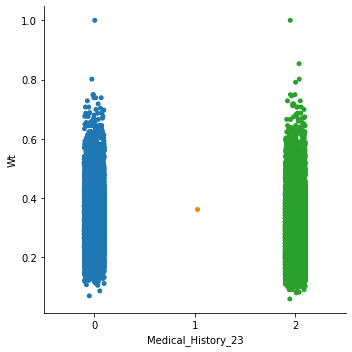

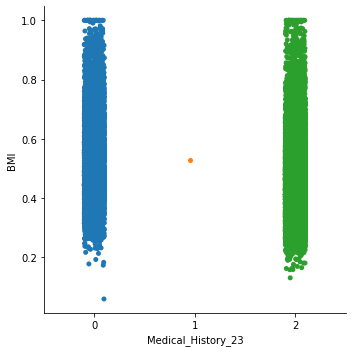

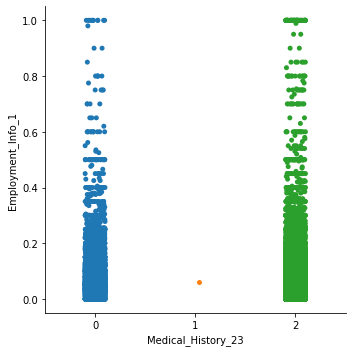

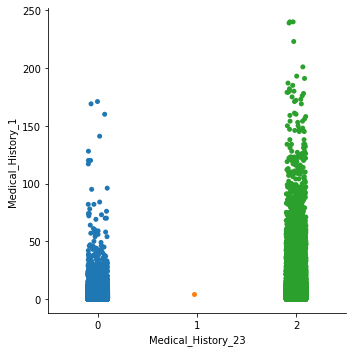

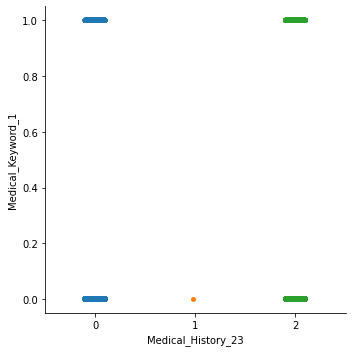

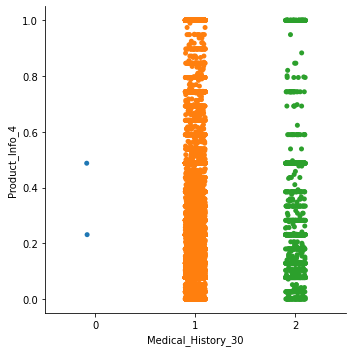

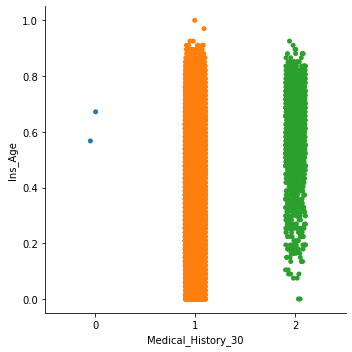

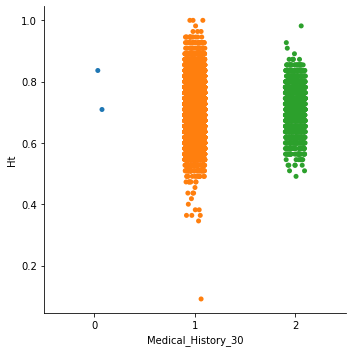

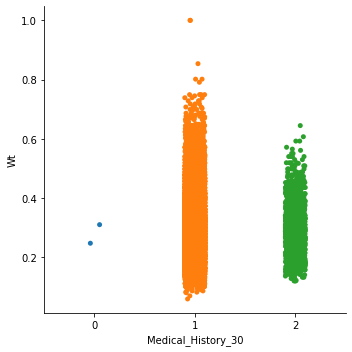

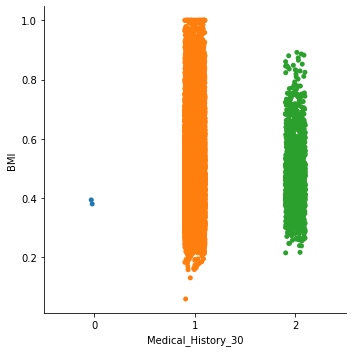

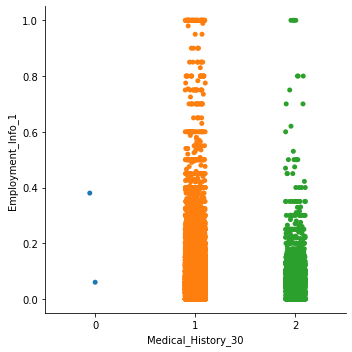

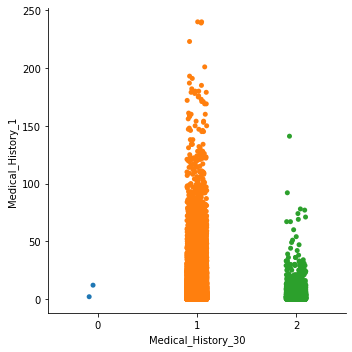

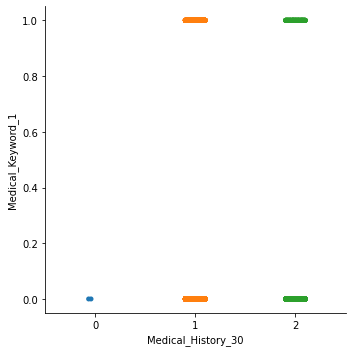

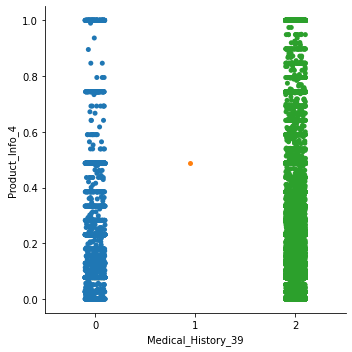

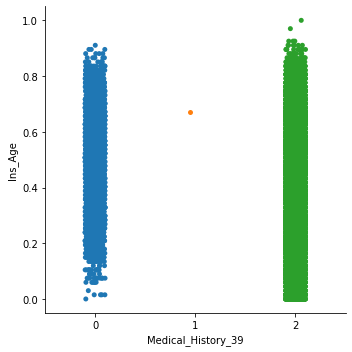

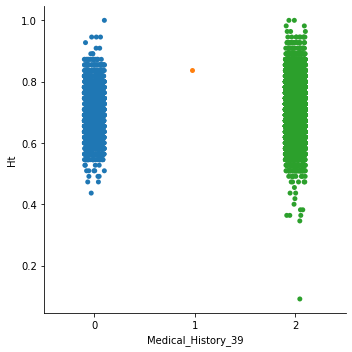

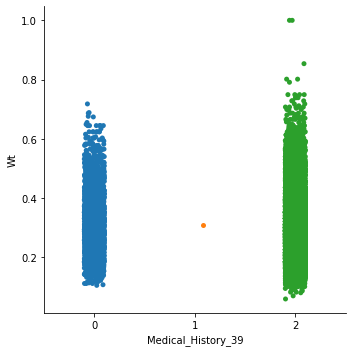

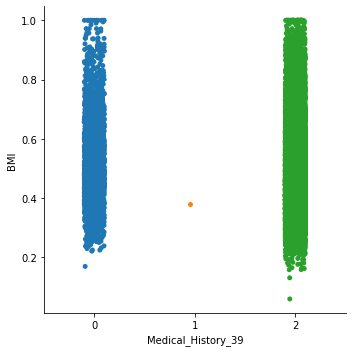

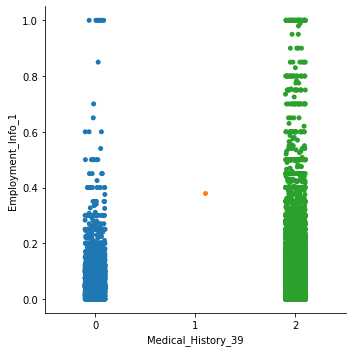

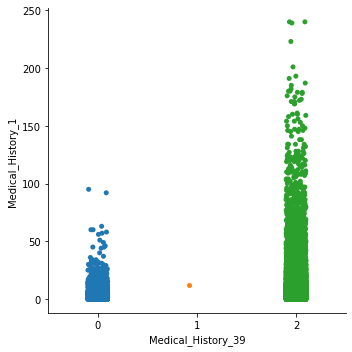

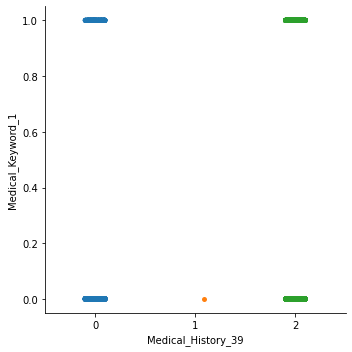

In [326]:
n=lstContinuous+lstDiscrete
for col in selectedCatColumns:
  for c in n:
    sns.catplot(x=col, y=c, data=X_train)

## **

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


 >ExtraTrees 0.463 (0.012) 


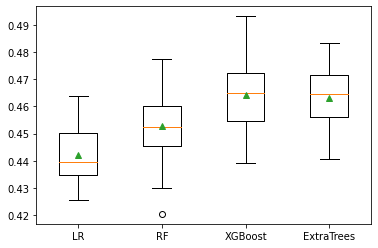

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


 >ExtraTrees 0.463 (0.012) 


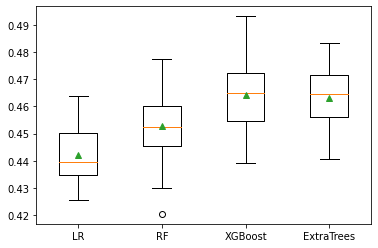

In [291]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import cohen_kappa_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier


# evaluate a model
def evaluate_model(X, y, model):
  # define evaluation procedure
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  # define the model evaluation metric
  metric = make_scorer(cohen_kappa_score,weights='quadratic')
  # evaluate model
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores


def get_models():
  models, names = list(), list()
  # LR
  LR=[('Standardized',StandardScaler()),('LR',LogisticRegression(solver= 'lbfgs',class_weight='balanced' ))]
  models.append(LR)
  names.append( 'LR' )
  
  RF=[('Standardized',StandardScaler()),('STRF',RandomForestClassifier(n_estimators=100, max_features=3,class_weight='balanced' ))]
  models.append(RF)
  names.append( 'RF')

  XGBoost=[('Standardized',StandardScaler()),('XgBoost',XGBClassifier(class_weight='balanced',n_estimators=200))]
  models.append(XGBoost)
  names.append( 'XGBoost' )

  ExtraTrees=[('Standardized',StandardScaler()),('ExtraTrees',ExtraTreesClassifier(class_weight='balanced' ,n_estimators=100, max_features=5))]
  models.append(ExtraTrees)
  names.append( 'ExtraTrees' )
  return models, names


# define models
models, names = get_models()
results = list()
# evaluate each model
for i in range(len(models)):
  # create a pipeline
  steps = models[i]
  pipeline = Pipeline(steps=steps)
  # evaluate the model and store results
  scores = evaluate_model(X_train, y_train, pipeline)
  results.append(scores)

# summarize and store
print( ' >%s %.3f (%.3f) ' % (names[i], np.mean(scores), np.std(scores)))
# plot the results
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [389]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

gridXg=XGBClassifier()
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
colsample_bytree = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
subsample = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
colsample_bylevel = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
kfold = StratifiedKFold( n_splits=3, shuffle=True, random_state=7)
param_grid = dict(colsample_bylevel=colsample_bylevel)
grid_search = GridSearchCV(gridXg, param_grid, scoring=make_scorer(cohen_kappa_score,weights='quadratic'), n_jobs=-1, cv=kfold, verbose=1)
result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (result.best_score_, result.best_params_))


Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  4.2min finished


Best: 0.457234 using {'subsample': 0.2}


In [480]:
param_grid = {'max_depth': [3,4,None]}
tree_model = GridSearchCV(DecisionTreeClassifier(random_state=0),
                          cv = 5, 
                          scoring = 'neg_log_loss',
                          param_grid = param_grid)
tree_model.fit(X_train[selectedCatColumns], y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=0, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [3, 4, None]}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False

In [0]:

X_train['new_feat'] = tree_model.predict_log_proba(X_train[selectedCatColumns])
X_test['new_feat'] = tree_model.predict_log_proba(X_test[selectedCatColumns])

In [474]:
X_test['new_feat']

0       -2.299490
1       -2.889377
2       -2.299490
3       -2.722186
4       -2.889377
           ...   
17810   -2.889377
17811   -1.958015
17812   -1.958015
17813   -2.299490
17814   -2.705229
Name: new_feat, Length: 17815, dtype: float64

## **XGBoost Performed Better on cv**

In [488]:
classWeights = {7: 30, 1: 100, 2: 50, 3: 200, 4: 30, 5: 10, 6: 2, 8: 1}

xg=XGBClassifier(class_weight=classWeights,n_estimators=200,max_depth=4,learning_rate=0.2,colsample_bytree=0.8,subsample= 0.2)
xg.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree',
              class_weight={1: 100, 2: 50, 3: 200, 4: 30, 5: 10, 6: 2, 7: 30,
                            8: 1},
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              gamma=0, learning_rate=0.2, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.2, verbosity=1)

In [0]:
y_pred=xg.predict(X_test)

In [490]:
cohen_kappa_score(y_test,y_pred,weights='quadratic')

0.4773938921567804

0.5164748807184957

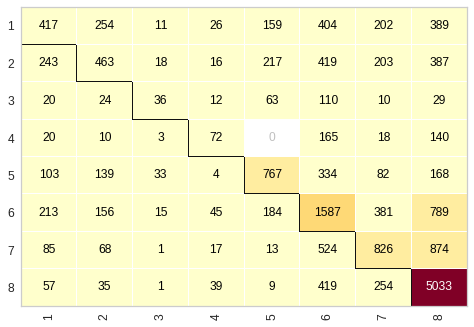

In [491]:

from yellowbrick.classifier import ConfusionMatrix

cm = ConfusionMatrix(xg, classes=[1,2,3,4,5,6,7,8])
cm.score(X_test, y_test)



In [0]:
y_sub=xg.predict(test)

In [492]:
X_train.columns

Index(['Product_Info_4', 'Ht', 'Employment_Info_1', 'Medical_Keyword_1',
       'Product_Info_2', 'Employment_Info_2', 'Employment_Info_3',
       'InsuredInfo_6', 'Medical_History_2', 'Medical_History_4',
       'Medical_History_6', 'Medical_History_13', 'Medical_History_16',
       'Medical_History_23', 'Medical_History_30', 'Medical_History_33',
       'Medical_History_39', 'Medical_History_40', 'BMI_Age', 'BMI_LOG',
       'Ins_Age_exp', 'Wt_LOG', 'Medical_History_1_LOG'],
      dtype='object')

In [0]:
test['Response']=y_sub
test_og=pd.read_csv("test.csv")
test['Id']=test_og['Id']

In [0]:
test[['Id','Response']].to_csv('submission.csv',index=False)

Product_Info_4        Ht  ...    Wt_LOG  Medical_History_1_LOG
0            0.487179  0.781818  ...  0.291857               1.098612
1            0.076923  0.727273  ...  0.271336               1.791759
2            0.144667  0.709091  ...  0.277695               1.386294
3            0.151709  0.654545  ...  0.237269               1.609438
4            0.076923  0.672727  ...  0.220630               2.944439
...               ...       ...  ...       ...                    ...
19760        0.128205  0.636364  ...  0.142124               2.079442
19761        0.230769  0.618182  ...  0.203709               2.397895
19762        0.076923  0.727273  ...  0.346582               1.098612
19763        0.487179  0.745455  ...  0.424803               1.609438
19764        1.000000  0.781818  ...  0.324143               1.609438

[19765 rows x 18 columns]

In [0]:
from category_encoders import CatBoostEncoder
from category_encoders import JamesSteinEncoder
from category_encoders import OneHotEncoder
CBE_encoder = CatBoostEncoder(cols=['Medical_History_23', 'Medical_History_13', 'Medical_History_6', 'Medical_History_40', 'Medical_History_39', 'Medical_History_4', 'Medical_History_33', 'Product_Info_2', 'InsuredInfo_6'])
lstCols=['Medical_History_23', 'Medical_History_13', 'Medical_History_6', 'Medical_History_40', 'Medical_History_39', 'Medical_History_4', 'Medical_History_33', 'Product_Info_2', 'InsuredInfo_6']
js = JamesSteinEncoder(cols=['Medical_History_23', 'Medical_History_13', 'Medical_History_6', 'Medical_History_40', 'Medical_History_39', 'Medical_History_4', 'Medical_History_33', 'Product_Info_2', 'InsuredInfo_6'])

oh=OneHotEncoder(cols=lstCols)
train_cbe = CBE_encoder.fit_transform(X_train, y_train)
test_cbe = CBE_encoder.transform(X_test)


train_js = js.fit_transform(X_train, y_train)
test_js = js.transform(X_test)

oh=OneHotEncoder(cols=lstCols)

train_oh = oh.fit_transform(X_train, y_train)
test_oh = oh.transform(X_test)

In [0]:
test=pd.read_csv("test.csv")

In [433]:
classWeights = {7: 30, 1: 100, 2: 50, 3: 80, 4: 30, 5: 70, 6: 50, 8: 1}

xgCatBoost=XGBClassifier(class_weight=classWeights,n_estimators=200,max_depth=4,learning_rate=0.2,colsample_bytree=0.8)
xgCatBoost.fit(train_oh,y_train)

XGBClassifier(base_score=0.5, booster='gbtree',
              class_weight={1: 100, 2: 50, 3: 80, 4: 30, 5: 70, 6: 50, 7: 30,
                            8: 1},
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              gamma=0, learning_rate=0.2, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [434]:
y_pred_cat_boost=xgCatBoost.predict(test_oh)
cohen_kappa_score(y_test,y_pred_cat_boost,weights='quadratic')

0.4757384600652991

0.520123491439798

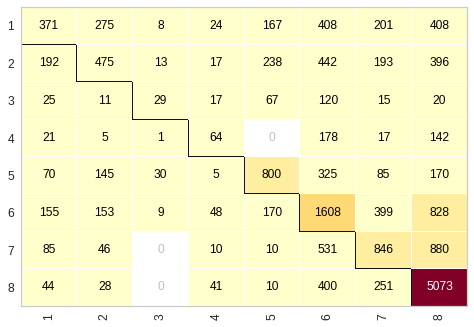

In [435]:

cm = ConfusionMatrix(xgCatBoost, classes=[1,2,3,4,5,6,7,8])
cm.score(test_oh, y_test)


In [0]:

poly = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)
poly.fit(X_train[['BMI_LOG','Ht', 	'Ins_Age_exp', 	'Wt_LOG','Medical_History_1_LOG']])
train_t = poly.transform(X_train[['BMI_LOG','Ht', 	'Ins_Age_exp', 	'Wt_LOG','Medical_History_1_LOG']])
test_t = poly.transform(X_test[['BMI_LOG','Ht', 	'Ins_Age_exp', 	'Wt_LOG','Medical_History_1_LOG']])

In [439]:
train_t_df = pd.DataFrame(train_t)

train_t_df.columns = poly.get_feature_names(['BMI_LOG','Ht', 	'Ins_Age_exp', 	'Wt_LOG','Medical_History_1_LOG'])

test_t_df = pd.DataFrame(test_t)

test_t_df.columns = poly.get_feature_names(['BMI_LOG','Ht', 	'Ins_Age_exp', 	'Wt_LOG','Medical_History_1_LOG'])

train_t_df

BMI_LOG  ...  Medical_History_1_LOG^3
0      0.333142  ...                19.859583
1      0.380275  ...                13.787662
2      0.397948  ...                 2.664197
3      0.416333  ...                13.787662
4      0.317455  ...                 8.991666
...         ...  ...                      ...
41561  0.508226  ...                48.132660
41562  0.536580  ...                 4.168912
41563  0.368617  ...                55.161125
41564  0.277337  ...                16.874713
41565  0.408364  ...                 4.168912

[41566 rows x 55 columns]

In [0]:
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

In [0]:
X_train_new=pd.concat([X_train,train_t_df],axis=1)
X_test_new=pd.concat([X_test,test_t_df],axis=1)
X_train_new = X_train_new.loc[:,~X_train_new.columns.duplicated()]
X_test_new = X_test_new.loc[:,~X_test_new.columns.duplicated()]

In [452]:
classWeights = {7: 30, 1: 100, 2: 50, 3: 80, 4: 30, 5: 70, 6: 50, 8: 1}

xgCatBoost=XGBClassifier(class_weight=classWeights,n_estimators=200,max_depth=4,learning_rate=0.2,colsample_bytree=0.8)
xgCatBoost.fit(X_train_new,y_train)

XGBClassifier(base_score=0.5, booster='gbtree',
              class_weight={1: 100, 2: 50, 3: 80, 4: 30, 5: 70, 6: 50, 7: 30,
                            8: 1},
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              gamma=0, learning_rate=0.2, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [453]:
y_pred_cat_boost=xgCatBoost.predict(X_test_new)
cohen_kappa_score(y_test,y_pred_cat_boost,weights='quadratic')

0.47502696124149324